# Imports

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

%reload_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

from typing import List, Tuple, Union, Sequence

import sys
import os

#https://github.com/FAU-DLM/wsi_processing_pipeline
sys.path.append("../")
sys.path.append("../wsi_processing_pipeline/")
sys.path.append("../wsi_processing_pipeline/tile_extraction")
sys.path.append("../wsi_processing_pipeline/shared")
import wsi_processing_pipeline
import tile_extraction
import preprocessing
import postprocessing
import shared
from wsi_processing_pipeline.shared import roi
from wsi_processing_pipeline.tile_extraction import tiles, util, slide, filter
from wsi_processing_pipeline.preprocessing import *
import wsi_processing_pipeline.preprocessing.files_getter
import wsi_processing_pipeline.preprocessing.name_getter
from wsi_processing_pipeline.preprocessing.name_getter import NameGetter
from wsi_processing_pipeline.preprocessing.tile_image_block import TileImage, label_tl_image, tile_image, TileTransform
from wsi_processing_pipeline.preprocessing.tile_image_block import show_batch, TileImageBlock
from shared.patient_manager import PatientManager
from shared.enums import DatasetType, EvaluationLevel

sys.path.append('../models-pytorch/pretrained-models.pytorch')
import pretrainedmodels
from pretrainedmodels import *

import PIL


import fastai
from fastai.vision.all import *
from typing import Dict
import pandas
import pandas as pd
import numpy
import numpy as np
import os
import torch
torch.backends.cudnn.benchmark=True
import torchvision
from torchvision.models import *
from torchsummary import summary
from functools import partial, update_wrapper
from tqdm import tqdm_notebook as tqdm
import matplotlib.image as mpimg
import shutil

# to fix python OSError: broken data stream when reading image file
# https://stackoverflow.com/questions/42462431/oserror-broken-data-stream-when-reading-image-file
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import sklearn
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from tqdm.notebook import tqdm

import pathlib
from pathlib import Path
Path.ls = lambda x: [p for p in list(x.iterdir()) if '.ipynb_checkpoints' not in p.name]


from concurrent.futures import as_completed, ProcessPoolExecutor
from tqdm import tqdm
import json

#against DecompressionBombWarning
Image.MAX_IMAGE_PIXELS = 10000000000   

PATH = Path('/home/Deep_Learner/private/datasets/urothel_ca')
PATH_WSIS = PATH/'Neue_Scans_Urothelkarzinome'
#PATH_ROIS = PATH/'Rois_Christoph'
PATH_ROIS = PATH/'Rois_Samir'
PATH_ROIS_ADJUSTED = PATH/'Rois_Samir_adjusted'
PATH_EXCEL_SHEET = PATH/'Data_Sheet_MIER_22112021.xlsx'


seed = 42
np.random.seed(seed)

# Data 

In [ ]:
wsi_mrxs_paths = [p for p in PATH_WSIS.ls() if p.suffix == '.mrxs']
len(wsi_mrxs_paths)

In [ ]:
wsi_dir_paths = [p for p in PATH_WSIS.ls() if p.suffix == '']
len(wsi_dir_paths)

In [ ]:
json_paths = PATH_ROIS.ls()
len(json_paths)

## get rois for each wsi path

### wsi path to json file mapping

In [ ]:
def find_json_path(mrxs_path:pathlib.Path)->pathlib.Path:
    stem = mrxs_path.stem
    for jp in json_paths:
        if(jp.stem == stem):
            return jp
    return None

In [7]:
wsi_mrxs_to_json_path = {}
wsi_mrxs_paths_without_corresponding_json_file = []
for mrxs_p in wsi_mrxs_paths:
    jp = find_json_path(mrxs_path=mrxs_p)
    if(jp is not None):
        wsi_mrxs_to_json_path[mrxs_p] = jp
    else:
        wsi_mrxs_paths_without_corresponding_json_file.append(mrxs_p)

In [8]:
len(wsi_mrxs_to_json_path)

233

In [9]:
len(wsi_mrxs_paths_without_corresponding_json_file)

6

### custom function that creates PolygonHelper objects from a given json file with the roi coordinates

In [10]:
class __PolygonHelper:
    def __init__(self, level:int, vertices:Sequence[Tuple[float, float]]):
        self.level = level
        self.vertices = vertices

def get_polygons_from_json(json_path:pathlib.Path)->List[__PolygonHelper]:
    """
    Reads the json file and returns a list of __PolygonHelper objects. 
    This should be a specialized function for the specific structure of your json files.
    
    Arguments:
        json_path: path to json file
        
    Returns:
        List of __PolygonHelper objects
    """
    polygons = []
    with open(json_path) as json_file:
        for i, annotation in enumerate(json.load(json_file)):
            #some annotations do not have a "classification" prop
            # => just skip them
            try:
                annotation["properties"]["classification"]
            except KeyError as ke:
                print(ke)
                print(f'annotation num: {i}')
                continue
                
            #skip rois that are not classified as Tumor
            if(annotation["properties"]["classification"]["name"] == "Tumor"):
                if(annotation["geometry"]["type"] == 'MultiPolygon'):
                    multi_polygon_vertices = annotation["geometry"]["coordinates"]
                    #print(f'Multi Polygon: {np.array(multi_polygon_vertices).squeeze().shape}')
                    ##QuPath produces Polygons and Multipolygons 
                    ##(see difference here: https://gis.stackexchange.com/questions/225368/understanding-difference-between-polygon-and-
                    ##multipolygon-for-shapefiles-in-qgis/225373)
                    ##This loop separates Multipolygons into individual Polygons
                    for sub_polygon_vertices in multi_polygon_vertices:
                        sub_polygon_vertices_array = np.array(sub_polygon_vertices, dtype=object).squeeze()
                        if(len(sub_polygon_vertices_array.shape) == 2 and sub_polygon_vertices_array.shape[1] == 2):
                            #print(f'/1/: {sub_polygon_vertices_array.shape}')
                            polygons.append(__PolygonHelper(level=0, vertices=sub_polygon_vertices_array))
                        else:
                            for elem in sub_polygon_vertices_array:
                                elem_array = np.array(elem).squeeze()
                                #print(f'/2/: {elem_array.shape}')
                                polygons.append(__PolygonHelper(level=0, vertices=elem_array))
                    
                elif(annotation["geometry"]["type"] == 'Polygon'):
                    vertices = annotation["geometry"]["coordinates"]
                    #print(f'/3/ len of vertices: {len(vertices)}')
                    for ls in vertices:               
                        #print(f'/4/: {np.array(ls).squeeze().shape}')
                        polygons.append(__PolygonHelper(level=0, vertices=np.array(ls, dtype=object).squeeze()))
                else:
                    assert False
    return polygons

### adjust misalligned rois because of black and white padding when mrxs files are opened by openslide

In [11]:
def is_row_black(img:Union[PIL.Image.Image, numpy.ndarray], row_num:int)->bool:
    if(type(img) is PIL.Image.Image):
        img = util.pil_to_np_rgb(img)
    return np.all(img[row_num, :, :] == [0,0,0])

def is_column_black(img:Union[PIL.Image.Image, numpy.ndarray], column_num:int)->bool:
    if(type(img) is PIL.Image.Image):
        img = util.pil_to_np_rgb(img)
    return np.all(img[:, column_num, :] == [0,0,0])

def get_num_of_black_rows_at_top(img:Union[PIL.Image.Image, numpy.ndarray])->int:
    n_rows = 0
    while(is_row_black(img=img, row_num=n_rows)):
        n_rows += 1
    return n_rows

def get_num_of_black_columns_at_left(img:Union[PIL.Image.Image, numpy.ndarray])->int:
    n_columns = 0
    while(is_column_black(img=img, column_num=n_columns)):
        n_columns += 1
    return n_columns

class Row_or_col(Enum):
    ROW = 1
    COLUMN = 2
    
def is_only_black_white(img:Union[PIL.Image.Image, numpy.ndarray], index:int, row_or_col:Row_or_col)->bool:
    """
    checks if the by index specified row or column in the image contains only [0,0,0] == black
    or [255,255,255] == white RGB values
    """
    if(type(img) is PIL.Image.Image):
        img = util.pil_to_np_rgb(img)
    a = None
    if(row_or_col is Row_or_col.ROW):
        a = img[index, :, :]
    elif(row_or_col is Row_or_col.COLUMN):
        a = img[:, index, :]
    else:
        raise ValueError('row_or_col has insufficient value')
    return np.where(np.logical_and(np.ravel(a) > 0, np.ravel(a) < 255))[0].size == 0

def get_num_of_only_black_white(img:Union[PIL.Image.Image, numpy.ndarray], row_or_col:Row_or_col)->int:
    n = 0
    while(is_only_black_white(img=img, index=n, row_or_col=row_or_col)):
        n += 1
    return n

def adjust_rois(wsi_img:Union[PIL.Image.Image, numpy.ndarray], 
                wsi_img_level:int, 
                rois:List[roi.RegionOfInterestPolygon]):
    """
    returns new RegionOfInterestPolygon objects
    """
    cols_left = get_num_of_only_black_white(img=wsi_img, row_or_col=Row_or_col.COLUMN)
    rows_top = get_num_of_only_black_white(img=wsi_img, row_or_col=Row_or_col.ROW)
    rois_adjusted = []
    for r in rois:
        new_vertices = util.polygon_to_numpy(r.polygon)
        new_vertices += [util.adjust_level(value_to_adjust=cols_left, from_level=wsi_img_level, to_level=r.level), 
                         util.adjust_level(value_to_adjust=rows_top, from_level=wsi_img_level, to_level=r.level)]
        r_new = roi.RegionOfInterestPolygon(roi_id=r.roi_id, vertices=new_vertices, level=r.level)
        rois_adjusted.append(r_new)

    return rois_adjusted

def save_as_pickle(obj:object, path):
    with open(path, 'wb') as file:
        pickle.dump(obj, file)

def load_pickle(path):
    with open(path, 'rb') as file:
        return pickle.load(file)

def adjust_and_save_rois(wsi_path, json_path):
    print(f'wsi: {wsi_path.name}')
    print(f'json: {json_path.name}')
        
    save_name = f'{wsi_path.stem}-rois_adjusted.pickle'
    save_path = PATH_ROIS_ADJUSTED/save_name
    if(not save_path.exists()):    
        wh = tiles.WsiHandler(wsi_path=wsi_path)
        rois = roi.get_list_of_RegionOfInterestPolygon_from_json(json_path=json_path, 
                                        polygons_from_json_func=get_polygons_from_json)       
        rois_adjusted = adjust_rois(wsi_img=wh.get_wsi_as_pil_image(level=5), wsi_img_level=5, rois=rois)               
        save_as_pickle(rois_adjusted, save_path)
    else:
        print(f'Already exists: {save_path}')    

In [12]:
failed = []
for wsi_path, json_path in tqdm(list(wsi_mrxs_to_json_path.items())[:]):
    try:
        roi.adjust_and_save_rois(wsi_path, json_path)
    except:
        failed.append(wsi_path)

100%|██████████| 233/233 [00:00<00:00, 377471.16it/s]


In [13]:
#no stroma rois
wsi_path_to_rois = {}
for wsi_path, json_path in tqdm(list(wsi_mrxs_to_json_path.items())[:]):
    save_name = f'{wsi_path.stem}-rois_adjusted.pickle'
    save_path = PATH_ROIS_ADJUSTED/save_name
    rois = load_pickle(save_path)
    wsi_path_to_rois[wsi_path] = rois

100%|██████████| 233/233 [00:22<00:00, 10.22it/s]


## id and label funcs

In [15]:
data_sheet = pd.read_excel(PATH_EXCEL_SHEET, engine='openpyxl')

# one case per patient => patient id == case id
def get_patient_id_from_wsi_path(wsi_path:pathlib.Path)->str:
    return get_case_id_from_wsi_path(wsi_path=wsi_path)
    
def get_case_id_from_wsi_path(wsi_path:pathlib.Path)->str:
    split = wsi_path.stem.split('_')
    return f'{split[0]}_{split[1]}'    

def get_slide_id_from_wsi_path(wsi_path:pathlib.Path)->str:
    return wsi_path.stem

def get_labels_from_wsi_path(wsi_path:pathlib.Path, roi=None)->List[int]:
    tma_nr = wsi_path.stem.split('_')[1]
    row = data_sheet.iloc[int(tma_nr)-1]
    histology = row['Histology']
    variant_histology = row['Variant Histology']
    return [histology, variant_histology]

## tiles

In [16]:
tilesummaries_save_path = Path(f'./tilesummaries/001/')
tilesummaries = []

tilesummaries_saved_names = [p.stem for p in tilesummaries_save_path.ls()]

for wsi_path in tqdm(list(wsi_path_to_rois.keys())):
#for wsi_path in tqdm(list(failed_wsi_paths.keys())[:]):
    if(f'{wsi_path.stem}_tilesummary' in tilesummaries_saved_names):
        print(f'{wsi_path.stem} is loaded ...')
        tilesummaries.append(load_pickle(tilesummaries_save_path/f'{wsi_path.stem}_tilesummary.pickle'))
        pass
    else:
        print(f'{wsi_path.stem} tiles are calculated ...')    
        t = tiles.WsisToTilesParallel(wsi_paths=[wsi_path],
                                          tile_height=1024, 
                                          tile_width=1024, 
                                          tile_scoring_function=tiles.score_tile_1,
                                          tile_score_thresh=0.2, 
                                          level=0, 
                                          wsi_path_to_rois=wsi_path_to_rois,
                                          minimal_tile_roi_intersection_ratio=0.95, 
                                          verbose=True, 
                                          grids_per_roi=1, 
                                          optimize_grid_angles=False)[0]
        tilesummaries.append(t)
        p = tilesummaries_save_path/f'{t.wsi_path.stem}_tilesummary.pickle'
        save_as_pickle(t, p)

  0%|          | 0/233 [00:00<?, ?it/s]

MIER_140_M17 is loaded ...
MIER_151_M3 is loaded ...


  1%|          | 2/233 [00:00<00:26,  8.88it/s]

MIER_158_TUR2 is loaded ...


  2%|▏         | 5/233 [00:00<00:28,  8.03it/s]

MIER_175_M12 is loaded ...
MIER_200_M9 is loaded ...
MIER_211_C is loaded ...
MIER_217_C is loaded ...


  3%|▎         | 7/233 [00:00<00:24,  9.33it/s]

MIER_236_C is loaded ...
MIER_40_D is loaded ...


  4%|▍         | 9/233 [00:01<00:27,  8.07it/s]

MIER_52_B is loaded ...


  5%|▌         | 12/233 [00:01<00:28,  7.64it/s]

MIER_74_M10 is loaded ...
MIER_184_I is loaded ...
MIER_46_A is loaded ...


  6%|▌         | 13/233 [00:01<00:27,  8.13it/s]

MIER_134_TUR1 is loaded ...


  6%|▌         | 14/233 [00:01<00:32,  6.71it/s]

MIER_130_C is loaded ...


  7%|▋         | 16/233 [00:02<00:44,  4.93it/s]

MIER_233_TUR1 is loaded ...
MIER_127_G is loaded ...


  9%|▊         | 20/233 [00:02<00:27,  7.74it/s]

MIER_41_A is loaded ...
MIER_115_C is loaded ...
MIER_147_A is loaded ...
MIER_17_C is loaded ...


  9%|▉         | 22/233 [00:02<00:25,  8.35it/s]

MIER_183_A is loaded ...
MIER_222_M13 is loaded ...
MIER_50_A is loaded ...


 11%|█         | 25/233 [00:03<00:30,  6.93it/s]

MIER_79_D is loaded ...
MIER_167_L is loaded ...
MIER_187_M13 is loaded ...


 12%|█▏        | 27/233 [00:03<00:26,  7.80it/s]

MIER_145_B is loaded ...
MIER_71_H is loaded ...


 12%|█▏        | 29/233 [00:03<00:25,  8.06it/s]

MIER_6_C is loaded ...


 14%|█▎        | 32/233 [00:04<00:35,  5.62it/s]

MIER_229_TUR2 is loaded ...
MIER_154_M21 is loaded ...
MIER_8_B is loaded ...


 14%|█▍        | 33/233 [00:04<00:35,  5.68it/s]

MIER_36_A is loaded ...
MIER_22_E is loaded ...


 16%|█▌        | 37/233 [00:05<00:28,  6.96it/s]

MIER_221_C is loaded ...
MIER_70_B is loaded ...
MIER_35_F is loaded ...


 17%|█▋        | 40/233 [00:05<00:23,  8.11it/s]

MIER_142_M13 is loaded ...
MIER_29_C is loaded ...
MIER_164_C is loaded ...
MIER_225_G is loaded ...


 19%|█▉        | 44/233 [00:05<00:20,  9.35it/s]

MIER_131_B is loaded ...
MIER_91_C is loaded ...


 20%|██        | 47/233 [00:06<00:29,  6.25it/s]

MIER_13_C is loaded ...
MIER_14_A is loaded ...
MIER_201_B is loaded ...
MIER_110_TUR3 is loaded ...


 21%|██        | 49/233 [00:06<00:23,  7.73it/s]

MIER_117_E is loaded ...
MIER_202_G is loaded ...
MIER_182_TUR4 is loaded ...


 23%|██▎       | 53/233 [00:06<00:18,  9.48it/s]

MIER_161_B is loaded ...
MIER_107_M22 is loaded ...
MIER_51_C is loaded ...


 24%|██▎       | 55/233 [00:07<00:19,  8.92it/s]

MIER_82_TUR1 is loaded ...
MIER_95_B is loaded ...


 24%|██▍       | 57/233 [00:07<00:19,  8.90it/s]

MIER_237_M4 is loaded ...
MIER_23_G is loaded ...


 25%|██▌       | 59/233 [00:07<00:27,  6.24it/s]

MIER_199_M10 is loaded ...
MIER_15_B is loaded ...
MIER_16_B is loaded ...


 27%|██▋       | 63/233 [00:08<00:24,  6.80it/s]

MIER_26_B is loaded ...
MIER_75_B is loaded ...
MIER_85_M12 is loaded ...


 29%|██▉       | 67/233 [00:08<00:17,  9.61it/s]

MIER_156_M15 is loaded ...
MIER_189_TUR is loaded ...
MIER_170_TUR1 is loaded ...
MIER_196_D is loaded ...


 30%|██▉       | 69/233 [00:08<00:17,  9.24it/s]

MIER_190_D is loaded ...
MIER_144_TUR is loaded ...
MIER_206_M11 is loaded ...


 30%|███       | 71/233 [00:09<00:16,  9.68it/s]

MIER_128_C is loaded ...
MIER_195_A is loaded ...


 32%|███▏      | 75/233 [00:09<00:16,  9.59it/s]

MIER_223_TUR is loaded ...
MIER_11_A is loaded ...
MIER_125_B is loaded ...
MIER_109_A is loaded ...


 33%|███▎      | 78/233 [00:10<00:28,  5.47it/s]

MIER_112_TUR1 is loaded ...
MIER_108_J is loaded ...


 34%|███▍      | 79/233 [00:10<00:27,  5.63it/s]

MIER_169_TUR is loaded ...
MIER_101_TUR3 is loaded ...


 36%|███▌      | 83/233 [00:11<00:19,  7.60it/s]

MIER_235_C is loaded ...
MIER_241_M5 is loaded ...
MIER_39_D is loaded ...
MIER_100_B is loaded ...


 36%|███▋      | 85/233 [00:11<00:16,  9.01it/s]

MIER_136_A is loaded ...
MIER_218_A is loaded ...


 37%|███▋      | 87/233 [00:11<00:16,  9.09it/s]

MIER_244_A is loaded ...
MIER_193_TUR2 is loaded ...


 38%|███▊      | 89/233 [00:11<00:16,  8.69it/s]

MIER_162_TUR2 is loaded ...
MIER_7_E is loaded ...


 39%|███▉      | 91/233 [00:11<00:15,  8.90it/s]

MIER_4_A is loaded ...
MIER_73_B is loaded ...


 41%|████      | 95/233 [00:12<00:14,  9.59it/s]

MIER_28_E is loaded ...
MIER_3_D is loaded ...
MIER_168_M3 is loaded ...


 42%|████▏     | 98/233 [00:12<00:16,  8.07it/s]

MIER_133_B is loaded ...
MIER_163_M4 is loaded ...
MIER_62_A is loaded ...


 43%|████▎     | 100/233 [00:12<00:14,  8.91it/s]

MIER_242_TUR2 is loaded ...
MIER_63_M17 is loaded ...


 43%|████▎     | 101/233 [00:13<00:16,  8.07it/s]

MIER_57_M21 is loaded ...
MIER_58_C is loaded ...


 45%|████▌     | 105/233 [00:13<00:20,  6.13it/s]

MIER_231_M11 is loaded ...
MIER_150_M16 is loaded ...
MIER_213_C is loaded ...


 46%|████▌     | 107/233 [00:14<00:18,  6.81it/s]

MIER_116_A is loaded ...
MIER_234_TUR8 is loaded ...


 47%|████▋     | 110/233 [00:14<00:15,  8.15it/s]

MIER_137_D is loaded ...
MIER_111_TUR5 is loaded ...
MIER_56_M16 is loaded ...


 48%|████▊     | 112/233 [00:14<00:17,  7.04it/s]

MIER_68_TUR2 is loaded ...
MIER_103_B is loaded ...


 49%|████▉     | 114/233 [00:14<00:15,  7.78it/s]

MIER_105_F is loaded ...
MIER_113_M16 is loaded ...
MIER_185_TUR1 is loaded ...


 50%|████▉     | 116/233 [00:15<00:12,  9.28it/s]

MIER_186_M10 is loaded ...


 51%|█████     | 118/233 [00:15<00:13,  8.31it/s]

MIER_2_B is loaded ...
MIER_207_E is loaded ...


 51%|█████     | 119/233 [00:15<00:16,  6.73it/s]

MIER_226_A is loaded ...
MIER_228_A is loaded ...


 52%|█████▏    | 121/233 [00:15<00:16,  6.90it/s]

MIER_239_M1 is loaded ...
MIER_59_B is loaded ...


 53%|█████▎    | 123/233 [00:16<00:16,  6.72it/s]

MIER_83_M13 is loaded ...
MIER_92_TUR2 is loaded ...


 54%|█████▎    | 125/233 [00:16<00:14,  7.35it/s]

MIER_55_M11 is loaded ...
MIER_66_TUR1 is loaded ...


 55%|█████▍    | 127/233 [00:16<00:14,  7.36it/s]

MIER_138_TUR is loaded ...
MIER_34_B is loaded ...


 55%|█████▌    | 129/233 [00:16<00:13,  7.55it/s]

MIER_37_A is loaded ...


 57%|█████▋    | 132/233 [00:17<00:26,  3.76it/s]

MIER_42_C is loaded ...
MIER_87_M15 is loaded ...
MIER_165_B is loaded ...


 58%|█████▊    | 134/233 [00:18<00:21,  4.61it/s]

MIER_20_A is loaded ...
MIER_238_TUR2 is loaded ...


 58%|█████▊    | 136/233 [00:18<00:17,  5.41it/s]

MIER_209_M16 is loaded ...
MIER_114_M21 is loaded ...
MIER_33_C is loaded ...


 60%|██████    | 140/233 [00:18<00:11,  7.76it/s]

MIER_198_A is loaded ...
MIER_179_M13 is loaded ...
MIER_97_TUR1 is loaded ...


 61%|██████    | 142/233 [00:18<00:11,  8.14it/s]

MIER_157_M2 is loaded ...
MIER_141_F is loaded ...


 62%|██████▏   | 144/233 [00:19<00:11,  8.08it/s]

MIER_177_TUR2 is loaded ...
MIER_18_A is loaded ...


 63%|██████▎   | 147/233 [00:19<00:13,  6.21it/s]

MIER_227_E is loaded ...
MIER_159_TUR4 is loaded ...
MIER_152_TUR2 is loaded ...
MIER_27_A is loaded ...


 64%|██████▍   | 150/233 [00:20<00:11,  7.03it/s]

MIER_30_A is loaded ...
MIER_230_M12 is loaded ...


 65%|██████▌   | 152/233 [00:20<00:11,  7.20it/s]

MIER_60_G is loaded ...
MIER_9_B is loaded ...


 66%|██████▌   | 154/233 [00:20<00:14,  5.53it/s]

MIER_99_TUR1 is loaded ...
MIER_129_C is loaded ...
MIER_172_F is loaded ...


 68%|██████▊   | 158/233 [00:21<00:09,  7.62it/s]

MIER_173_B is loaded ...
MIER_176_TUR is loaded ...
MIER_180_F is loaded ...


 69%|██████▊   | 160/233 [00:21<00:08,  8.28it/s]

MIER_215_M18 is loaded ...
MIER_219_A is loaded ...
MIER_246_C is loaded ...


 70%|██████▉   | 162/233 [00:21<00:07,  9.28it/s]

MIER_38_G is loaded ...
MIER_61_A is loaded ...


 70%|███████   | 164/233 [00:21<00:07,  8.67it/s]

MIER_240_M16 is loaded ...
MIER_126_E is loaded ...


 72%|███████▏  | 167/233 [00:22<00:08,  8.06it/s]

MIER_174_D is loaded ...
MIER_203_M13 is loaded ...


 72%|███████▏  | 168/233 [00:23<00:26,  2.42it/s]

MIER_10_A is loaded ...


 73%|███████▎  | 171/233 [00:23<00:19,  3.20it/s]

MIER_232_M10 is loaded ...
MIER_72_A is loaded ...
MIER_76_B is loaded ...


 74%|███████▍  | 172/233 [00:23<00:16,  3.80it/s]

MIER_77_A is loaded ...


 75%|███████▌  | 175/233 [00:24<00:11,  5.12it/s]

MIER_102_D is loaded ...
MIER_32_A is loaded ...
MIER_84_TUR2 is loaded ...


 76%|███████▋  | 178/233 [00:24<00:08,  6.73it/s]

MIER_245_TUR1 is loaded ...
MIER_123_LK1 is loaded ...
MIER_192_D is loaded ...


 77%|███████▋  | 180/233 [00:24<00:08,  6.59it/s]

MIER_67_M20 is loaded ...
MIER_160_D is loaded ...


 78%|███████▊  | 182/233 [00:25<00:06,  7.58it/s]

MIER_214_A is loaded ...
MIER_139_TUR is loaded ...
MIER_188_M14 is loaded ...


 79%|███████▉  | 184/233 [00:25<00:05,  8.43it/s]

MIER_149_C is loaded ...
MIER_45_D is loaded ...


 81%|████████  | 188/233 [00:25<00:05,  8.72it/s]

MIER_143_TUR1 is loaded ...
MIER_224_TUR3 is loaded ...
MIER_69_TUR6 is loaded ...


 82%|████████▏ | 190/233 [00:26<00:06,  7.12it/s]

MIER_88_M6 is loaded ...
MIER_90_A is loaded ...


 82%|████████▏ | 192/233 [00:26<00:05,  7.53it/s]

MIER_12_A is loaded ...
MIER_124_TUR4 is loaded ...


 84%|████████▎ | 195/233 [00:26<00:04,  8.21it/s]

MIER_171_M18 is loaded ...
MIER_19_B is loaded ...
MIER_208_TUR4 is loaded ...


 85%|████████▍ | 197/233 [00:26<00:03,  9.50it/s]

MIER_21_A is loaded ...
MIER_243_TUR5 is loaded ...


 85%|████████▌ | 199/233 [00:26<00:03,  9.07it/s]

MIER_43_B is loaded ...
MIER_44_B is loaded ...
MIER_48_A is loaded ...


 87%|████████▋ | 202/233 [00:27<00:03,  8.70it/s]

MIER_96_M7 is loaded ...
MIER_98_TUR2 is loaded ...


 88%|████████▊ | 204/233 [00:27<00:04,  7.03it/s]

MIER_93_M9 is loaded ...
MIER_155_A is loaded ...


 89%|████████▉ | 207/233 [00:28<00:03,  7.67it/s]

MIER_191_M2 is loaded ...
MIER_216_TUR3 is loaded ...
MIER_220_D is loaded ...
MIER_49_A is loaded ...


 90%|████████▉ | 209/233 [00:28<00:03,  7.38it/s]

MIER_5_A is loaded ...


 91%|█████████ | 211/233 [00:29<00:09,  2.32it/s]

MIER_197_TUR1 is loaded ...
MIER_65_A is loaded ...


 91%|█████████ | 212/233 [00:30<00:07,  2.93it/s]

MIER_81_TUR1 is loaded ...
MIER_212_M10 is loaded ...


 92%|█████████▏| 214/233 [00:30<00:05,  3.64it/s]

MIER_146_B is loaded ...
MIER_181_M10 is loaded ...


 93%|█████████▎| 216/233 [00:30<00:03,  4.38it/s]

MIER_24_B is loaded ...
MIER_247_M11 is loaded ...


 94%|█████████▍| 219/233 [00:30<00:02,  5.23it/s]

MIER_104_E is loaded ...
MIER_25_B is loaded ...


 95%|█████████▍| 221/233 [00:31<00:01,  6.57it/s]

MIER_64_M4 is loaded ...
MIER_210_B is loaded ...
MIER_47_C is loaded ...


 97%|█████████▋| 225/233 [00:31<00:00,  8.37it/s]

MIER_204_A is loaded ...
MIER_178_TUR1 is loaded ...
MIER_121_D is loaded ...
MIER_53_G is loaded ...


 98%|█████████▊| 229/233 [00:31<00:00, 10.63it/s]

MIER_80_TUR3 is loaded ...
MIER_148_A is loaded ...
MIER_166_M21 is loaded ...
MIER_89_TUR3 is loaded ...


100%|██████████| 233/233 [00:32<00:00,  7.24it/s]

MIER_78_M17 is loaded ...
MIER_94_G is loaded ...


In [ ]:
ts = tilesummaries[0]

## patient_manager

In [17]:
patient_manager = PatientManager()

patient_manager.create_from_tilesummaries(tilesummaries=tilesummaries, 
                                          patient_id_getter=get_patient_id_from_wsi_path, 
                                          case_id_getter=get_case_id_from_wsi_path, 
                                          slide_id_getter=get_slide_id_from_wsi_path, 
                                          labels_getter=get_labels_from_wsi_path)

100%|██████████| 233/233 [00:41<00:00,  5.65it/s]


In [18]:
class_distribution_all_tiles = patient_manager.get_class_distribution(level=shared.enums.EvaluationLevel.tile, 
                                                            dataset_type=shared.enums.DatasetType.all)
class_distribution_all_tiles

(187430,
 {'Glandular': 1462,
  'Glycogen rich': 933,
  'LNUC': 6619,
  'Lymphoepithelioma-like': 682,
  'MPUC': 14690,
  'NOS': 75409,
  'NUC': 2059,
  'Neuroendocrine': 13829,
  'PUC': 6387,
  'Sarcomatoid': 22154,
  'Squamous': 48446,
  'Trophoblastoid': 757,
  'Urothelial': 181433},
 {'Glandular': 0.0078002454249586515,
  'Glycogen rich': 0.004977858400469508,
  'LNUC': 0.03531451741983674,
  'Lymphoepithelioma-like': 0.003638691778263885,
  'MPUC': 0.07837592701275142,
  'NOS': 0.40233153710718667,
  'NUC': 0.010985434562236569,
  'Neuroendocrine': 0.07378221202582297,
  'PUC': 0.03407672197620445,
  'Sarcomatoid': 0.1181987942165075,
  'Squamous': 0.25847516406124954,
  'Trophoblastoid': 0.004038841167369151,
  'Urothelial': 0.9680040548471429})

In [19]:
class_distribution_all_slides = patient_manager.get_class_distribution(level=shared.enums.EvaluationLevel.slide, 
                                                            dataset_type=shared.enums.DatasetType.all)
class_distribution_all_slides

(232,
 {'Glandular': 4,
  'Glycogen rich': 2,
  'LNUC': 7,
  'Lymphoepithelioma-like': 3,
  'MPUC': 12,
  'NOS': 96,
  'NUC': 5,
  'Neuroendocrine': 10,
  'PUC': 11,
  'Sarcomatoid': 21,
  'Squamous': 60,
  'Trophoblastoid': 1,
  'Urothelial': 225},
 {'Glandular': 0.017241379310344827,
  'Glycogen rich': 0.008620689655172414,
  'LNUC': 0.03017241379310345,
  'Lymphoepithelioma-like': 0.01293103448275862,
  'MPUC': 0.05172413793103448,
  'NOS': 0.41379310344827586,
  'NUC': 0.021551724137931036,
  'Neuroendocrine': 0.04310344827586207,
  'PUC': 0.04741379310344827,
  'Sarcomatoid': 0.09051724137931035,
  'Squamous': 0.25862068965517243,
  'Trophoblastoid': 0.004310344827586207,
  'Urothelial': 0.9698275862068966})

In [20]:
train_size = 0.8
validation_size = 0.1
test_size = 0.1

patient_manager.split(train_size=train_size, 
                      validation_size=validation_size, 
                      test_size=test_size, 
                      random_state=seed)

## data block api

In [21]:
final_size = 512
bs = 15


data = fastai.data.block.DataBlock(
        blocks=(TileImageBlock, fastai.data.block.MultiCategoryBlock),
        get_x=lambda x: x, 
        get_y=lambda x: x.get_labels(),
        splitter=fastai.data.transforms.FuncSplitter(lambda x: x.get_dataset_type() == shared.enums.DatasetType.validation),
        item_tfms=fastai.vision.augment.Resize(size=final_size, method = 'squish'),
        batch_tfms=fastai.vision.augment.aug_transforms(flip_vert=True))

In [22]:
dls = data.dataloaders(patient_manager.get_tiles(dataset_type=DatasetType.train)\
                        +patient_manager.get_tiles(dataset_type=DatasetType.validation), 
                       bs=bs, 
                       verbose=True)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Setting up Pipeline: <lambda> -> TileImage.create
Setting up Pipeline: <lambda> -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} -> OneHotEncode -- {'c': None}
Setting up after_item: Pipeline: Resize -- {'size': (512, 512), 'method': 'squish', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Dihedral -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}


/opt/conda/envs/DLM_Py3/lib/python3.7/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


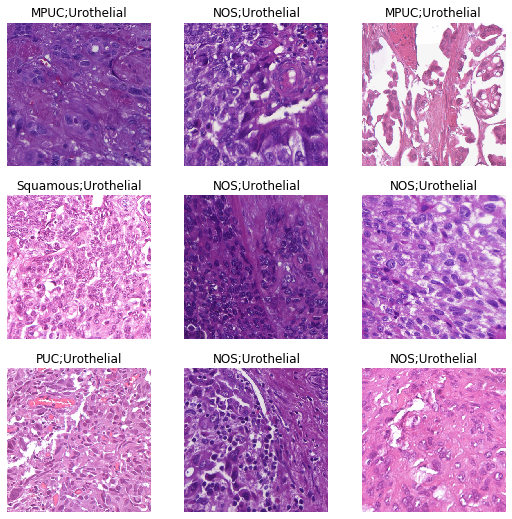

In [23]:
dls.show_batch()

# learner

## n

In [ ]:
n=2

## create

In [ ]:
arch = torchvision.models.resnet50

In [ ]:
learner = cnn_learner(dls=dls, 
                     arch=arch, 
                     metrics=[fastai.metrics.accuracy_multi],
                     pretrained=True,
                     path=PATH/'models'/f'{n}-{arch.__name__}')

In [ ]:
#learner.to_fp16()
print(learner.path)
learner.path.parent.mkdir(exist_ok=True)
learner.path.mkdir(exist_ok=True)

## name

In [34]:
epochs_frozen = 5
epochs_unfrozen = 10

In [35]:
nameBase = f'{n}-{arch.__name__}'
nameBase

'2-resnet50'

## train

In [ ]:
learner.lr_find(start_lr=1e-15, end_lr=10, num_it=200)

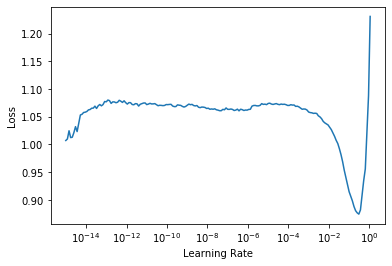

In [38]:
learner.recorder.plot_lr_find()

In [35]:
lr1 = 0.0012022644514217973

In [36]:
log_head_name = 'log-head.csv'

In [ ]:
learner.fit_one_cycle(n_epoch=epochs_frozen, 
                      lr_max=lr1, 
                      cbs=[CSVLogger(fname=log_head_name, append=True), SaveModelCallback(every_epoch=True, fname='head')])

epoch,train_loss,valid_loss,accuracy_multi,time


In [45]:
pd.read_csv(learner.path/log_head_name)

,epoch,train_loss,valid_loss,accuracy_multi,time
0,0,0.070999,0.473910,0.900775,2:31:36
1,1,0.051219,0.525429,0.895623,2:00:22
2,2,0.041063,0.561105,0.901993,2:03:16
3,3,0.034138,0.594680,0.904402,1:57:55
4,4,0.027999,0.657035,0.899384,1:58:44


In [ ]:
nameHead = f'{nameBase}-head';nameHead

In [ ]:
#learner.save(nameHead)
#learner.load(nameHead)

In [ ]:
learner.unfreeze()

SuggestedLRs(valley=6.42687725260771e-09)

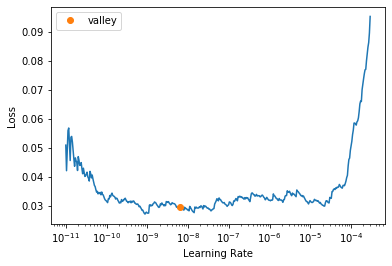

In [48]:
learner.lr_find(start_lr=1e-11, end_lr=1e-2, num_it=500)

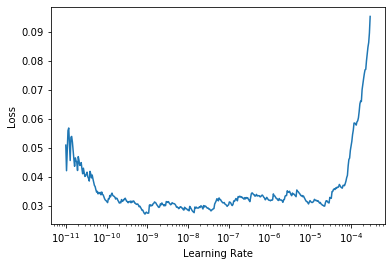

In [49]:
learner.recorder.plot_lr_find()

In [50]:
lr2 = 6.42687725260771e-10
lr3 = 6.42687725260771e-09
lr4 = 6.42687725260771e-08

In [51]:
log_complete_name = 'log-complete.csv'

In [ ]:
learner.fit_one_cycle(n_epoch=epochs_unfrozen, 
                      lr_max=[lr2, lr3, lr4], 
                      cbs=[CSVLogger(fname=log_complete_name, append=True), SaveModelCallback(every_epoch=True, fname='complete')])

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.029206,0.665021,0.899930,1:57:22


In [56]:
pd.read_csv(learner.path/log_complete_name)

,epoch,train_loss,valid_loss,accuracy_multi,time
0,0,0.029206,0.665021,0.899930,1:57:22
1,1,0.030227,0.666075,0.895947,2:00:16
2,2,0.027921,0.656340,0.897149,1:55:05
3,3,0.030665,0.659437,0.899572,1:55:45
4,4,0.030497,0.660615,0.897271,1:54:33
5,5,0.031689,0.644811,0.900542,1:55:24
6,6,0.027648,0.641850,0.900093,1:57:30
7,7,0.031292,0.669513,0.898365,2:09:13
8,8,0.025945,0.706452,0.892971,1:41:23
9,9,0.030125,0.648313,0.900137,1:41:28


In [28]:
nameComplete = f'{nameBase}-complete'; nameComplete

'2-resnet50-complete'

In [29]:
#learner.save(nameComplete)
learner.load(nameComplete)

# prediction

In [30]:
from postprocessing.predictor import Predictor

## new predictions

In [34]:
predictor = Predictor(learner=learner, 
                      patient_manager=patient_manager, 
                      prediction_type=shared.enums.PredictionType.classification_multicategory)

In [ ]:
predictor.predict_on_tiles(prediction_type=shared.enums.PredictionType.tiles_on_the_fly, 
                          dataset_type=shared.enums.DatasetType.validation,
                          tile_size=final_size, 
                          batch_size=bs)


  0%|          | 0/21082 [00:00<?, ?it/s]


  0%|          | 1/21082 [00:00<1:37:31,  3.60it/s]


  0%|          | 2/21082 [00:00<1:38:45,  3.56it/s]


  0%|          | 3/21082 [00:00<1:39:13,  3.54it/s]


  0%|          | 4/21082 [00:01<1:40:54,  3.48it/s]


  0%|          | 5/21082 [00:01<1:41:33,  3.46it/s]


  0%|          | 6/21082 [00:01<1:41:57,  3.44it/s]


  0%|          | 7/21082 [00:02<1:43:41,  3.39it/s]


  0%|          | 8/21082 [00:02<1:45:09,  3.34it/s]


  0%|          | 9/21082 [00:02<1:46:44,  3.29it/s]


  0%|          | 10/21082 [00:02<1:48:59,  3.22it/s]


  0%|          | 11/21082 [00:03<1:48:08,  3.25it/s]


  0%|          | 12/21082 [00:03<1:46:09,  3.31it/s]


  0%|          | 13/21082 [00:03<1:45:34,  3.33it/s]


  0%|          | 14/21082 [00:04<1:43:19,  3.40it/s]


  0%|          | 15/21082 [00:04<1:43:55,  3.38it/s]


  0%|          | 16/21082 [00:04<1:43:00,  3.41it/s]


  0%|          | 17/21082 [00:05<1:43:06,  3.40it/s]


  0%|          | 18/21082 [00:05<1:42:29,  3.43it/s]


  0%|          | 19/21082 [00:05<1:44:03,  3.37it/s]


  0%|          | 20/21082 [00:05<1:45:16,  3.33it/s]


  0%|          | 21/21082 [00:06<1:46:31,  3.30it/s]


  0%|          | 22/21082 [00:06<1:46:03,  3.31it/s]


  0%|          | 23/21082 [00:06<1:46:09,  3.31it/s]


  0%|          | 24/21082 [00:07<1:45:24,  3.33it/s]


  0%|          | 25/21082 [00:07<1:46:42,  3.29it/s]


  0%|          | 26/21082 [00:07<1:45:46,  3.32it/s]


  0%|          | 27/21082 [00:08<1:45:41,  3.32it/s]


  0%|          | 28/21082 [00:08<1:44:42,  3.35it/s]


  0%|          | 29/21082 [00:08<1:44:29,  3.36it/s]


  0%|          | 30/21082 [00:08<1:44:26,  3.36it/s]


  0%|          | 31/21082 [00:09<1:44:20,  3.36it/s]


  0%|          | 32/21082 [00:09<1:42:48,  3.41it/s]


  0%|          | 33/21082 [00:09<1:43:15,  3.40it/s]


  0%|          | 34/21082 [00:10<1:43:50,  3.38it/s]


  0%|          | 35/21082 [00:10<1:43:59,  3.37it/s]


  0%|          | 36/21082 [00:10<1:45:03,  3.34it/s]


  0%|          | 37/21082 [00:11<1:44:40,  3.35it/s]


  0%|          | 38/21082 [00:11<1:44:23,  3.36it/s]


  0%|          | 39/21082 [00:11<1:47:27,  3.26it/s]


  0%|          | 40/21082 [00:11<1:45:17,  3.33it/s]


  0%|          | 41/21082 [00:12<1:43:46,  3.38it/s]


  0%|          | 42/21082 [00:12<1:42:14,  3.43it/s]


  0%|          | 43/21082 [00:12<1:41:07,  3.47it/s]


  0%|          | 44/21082 [00:13<1:39:42,  3.52it/s]


  0%|          | 45/21082 [00:13<1:39:15,  3.53it/s]


  0%|          | 46/21082 [00:13<1:40:46,  3.48it/s]


  0%|          | 47/21082 [00:13<1:42:55,  3.41it/s]


  0%|          | 48/21082 [00:14<1:43:00,  3.40it/s]


  0%|          | 49/21082 [00:14<1:43:15,  3.39it/s]


  0%|          | 50/21082 [00:14<1:40:05,  3.50it/s]


  0%|          | 51/21082 [00:15<1:37:56,  3.58it/s]


  0%|          | 52/21082 [00:15<1:36:30,  3.63it/s]


  0%|          | 53/21082 [00:15<1:38:03,  3.57it/s]


  0%|          | 54/21082 [00:15<1:37:59,  3.58it/s]


  0%|          | 55/21082 [00:16<1:39:38,  3.52it/s]


  0%|          | 56/21082 [00:16<1:43:31,  3.39it/s]


  0%|          | 57/21082 [00:16<1:40:49,  3.48it/s]


  0%|          | 58/21082 [00:17<1:39:52,  3.51it/s]


  0%|          | 59/21082 [00:17<1:39:20,  3.53it/s]


  0%|          | 60/21082 [00:17<1:39:04,  3.54it/s]


  0%|          | 61/21082 [00:17<1:38:26,  3.56it/s]


  0%|          | 62/21082 [00:18<1:37:24,  3.60it/s]


  0%|          | 63/21082 [00:18<1:37:05,  3.61it/s]


  0%|          | 64/21082 [00:18<1:38:00,  3.57it/s]


  0%|          | 65/21082 [00:19<1:39:08,  3.53it/s]


  0%|          | 66/21082 [00:19<1:37:41,  3.59it/s]


  0%|          | 67/21082 [00:19<1:36:53,  3.61it/s]


  0%|          | 68/21082 [00:19<1:35:12,  3.68it/s]


  0%|          | 69/21082 [00:20<1:37:36,  3.59it/s]


  0%|          | 70/21082 [00:20<1:37:54,  3.58it/s]


  0%|          | 71/21082 [00:20<1:37:12,  3.60it/s]


  0%|          | 72/21082 [00:20<1:39:06,  3.53it/s]


  0%|          | 73/21082 [00:21<1:39:16,  3.53it/s]


  0%|          | 74/21082 [00:21<1:39:47,  3.51it/s]


  0%|          | 75/21082 [00:21<1:39:08,  3.53it/s]


  0%|          | 76/21082 [00:22<1:38:30,  3.55it/s]


  0%|          | 77/21082 [00:22<1:38:02,  3.57it/s]


  0%|          | 78/21082 [00:22<1:37:25,  3.59it/s]


  0%|          | 79/21082 [00:22<1:39:09,  3.53it/s]


  0%|          | 80/21082 [00:23<1:42:07,  3.43it/s]


  0%|          | 81/21082 [00:23<1:43:32,  3.38it/s]


  0%|          | 82/21082 [00:23<1:43:10,  3.39it/s]


  0%|          | 83/21082 [00:24<1:43:32,  3.38it/s]


  0%|          | 84/21082 [00:24<1:43:56,  3.37it/s]


  0%|          | 85/21082 [00:24<1:45:42,  3.31it/s]


  0%|          | 86/21082 [00:25<1:43:27,  3.38it/s]


  0%|          | 87/21082 [00:25<1:42:57,  3.40it/s]


  0%|          | 88/21082 [00:25<1:44:14,  3.36it/s]


  0%|          | 89/21082 [00:25<1:43:27,  3.38it/s]


  0%|          | 90/21082 [00:26<1:42:36,  3.41it/s]


  0%|          | 91/21082 [00:26<1:46:02,  3.30it/s]


  0%|          | 92/21082 [00:26<1:48:03,  3.24it/s]


  0%|          | 93/21082 [00:27<1:47:25,  3.26it/s]


  0%|          | 94/21082 [00:27<1:45:55,  3.30it/s]


  0%|          | 95/21082 [00:27<1:45:03,  3.33it/s]


  0%|          | 96/21082 [00:28<1:46:26,  3.29it/s]


  0%|          | 97/21082 [00:28<1:44:27,  3.35it/s]


  0%|          | 98/21082 [00:28<1:47:20,  3.26it/s]


  0%|          | 99/21082 [00:28<1:45:08,  3.33it/s]


  0%|          | 100/21082 [00:29<1:44:52,  3.33it/s]


  0%|          | 101/21082 [00:29<1:47:50,  3.24it/s]


  0%|          | 102/21082 [00:29<1:47:11,  3.26it/s]


  0%|          | 103/21082 [00:30<1:45:21,  3.32it/s]


  0%|          | 104/21082 [00:30<1:45:06,  3.33it/s]


  0%|          | 105/21082 [00:30<1:45:56,  3.30it/s]


  1%|          | 106/21082 [00:31<1:46:07,  3.29it/s]


  1%|          | 107/21082 [00:31<1:43:49,  3.37it/s]


  1%|          | 108/21082 [00:31<1:48:22,  3.23it/s]


  1%|          | 109/21082 [00:32<1:50:25,  3.17it/s]


  1%|          | 110/21082 [00:32<1:51:20,  3.14it/s]


  1%|          | 111/21082 [00:32<1:49:02,  3.21it/s]


  1%|          | 112/21082 [00:32<1:47:17,  3.26it/s]


  1%|          | 113/21082 [00:33<1:46:01,  3.30it/s]


  1%|          | 114/21082 [00:33<1:44:33,  3.34it/s]


  1%|          | 115/21082 [00:33<1:52:19,  3.11it/s]


  1%|          | 116/21082 [00:34<1:52:29,  3.11it/s]


  1%|          | 117/21082 [00:34<1:52:18,  3.11it/s]


  1%|          | 118/21082 [00:34<1:52:02,  3.12it/s]


  1%|          | 119/21082 [00:35<1:52:10,  3.11it/s]


  1%|          | 120/21082 [00:35<1:54:43,  3.05it/s]


  1%|          | 121/21082 [00:35<1:53:10,  3.09it/s]


  1%|          | 122/21082 [00:36<1:51:33,  3.13it/s]


  1%|          | 123/21082 [00:36<1:51:48,  3.12it/s]


  1%|          | 124/21082 [00:36<1:49:45,  3.18it/s]


  1%|          | 125/21082 [00:37<1:46:45,  3.27it/s]


  1%|          | 126/21082 [00:37<1:44:21,  3.35it/s]


  1%|          | 127/21082 [00:37<1:44:11,  3.35it/s]


  1%|          | 128/21082 [00:37<1:45:34,  3.31it/s]


  1%|          | 129/21082 [00:38<1:44:32,  3.34it/s]


  1%|          | 130/21082 [00:38<1:44:55,  3.33it/s]


  1%|          | 131/21082 [00:38<1:44:20,  3.35it/s]


  1%|          | 132/21082 [00:39<1:46:00,  3.29it/s]


  1%|          | 133/21082 [00:39<1:44:18,  3.35it/s]


  1%|          | 134/21082 [00:39<1:43:57,  3.36it/s]


  1%|          | 135/21082 [00:40<1:44:53,  3.33it/s]


  1%|          | 136/21082 [00:40<1:45:07,  3.32it/s]


  1%|          | 137/21082 [00:40<1:46:03,  3.29it/s]


  1%|          | 138/21082 [00:41<1:48:23,  3.22it/s]


  1%|          | 139/21082 [00:41<1:47:01,  3.26it/s]


  1%|          | 140/21082 [00:41<1:45:42,  3.30it/s]


  1%|          | 141/21082 [00:41<1:44:57,  3.33it/s]


  1%|          | 142/21082 [00:42<1:43:45,  3.36it/s]


  1%|          | 143/21082 [00:42<1:43:34,  3.37it/s]


  1%|          | 144/21082 [00:42<1:47:43,  3.24it/s]


  1%|          | 145/21082 [00:43<1:47:46,  3.24it/s]


  1%|          | 146/21082 [00:43<1:48:44,  3.21it/s]


  1%|          | 147/21082 [00:43<1:47:19,  3.25it/s]


  1%|          | 148/21082 [00:44<1:45:21,  3.31it/s]


  1%|          | 149/21082 [00:44<1:45:18,  3.31it/s]


  1%|          | 150/21082 [00:44<1:44:24,  3.34it/s]


  1%|          | 151/21082 [00:44<1:43:39,  3.37it/s]


  1%|          | 152/21082 [00:45<1:44:55,  3.32it/s]


  1%|          | 153/21082 [00:45<1:44:40,  3.33it/s]


  1%|          | 154/21082 [00:45<1:45:27,  3.31it/s]


  1%|          | 155/21082 [00:46<1:43:51,  3.36it/s]


  1%|          | 156/21082 [00:46<1:43:41,  3.36it/s]


  1%|          | 157/21082 [00:46<1:43:16,  3.38it/s]


  1%|          | 158/21082 [00:47<1:43:23,  3.37it/s]


  1%|          | 159/21082 [00:47<1:43:30,  3.37it/s]


  1%|          | 160/21082 [00:47<1:43:44,  3.36it/s]


  1%|          | 161/21082 [00:47<1:43:26,  3.37it/s]


  1%|          | 162/21082 [00:48<1:43:16,  3.38it/s]


  1%|          | 163/21082 [00:48<1:43:10,  3.38it/s]


  1%|          | 164/21082 [00:48<1:42:54,  3.39it/s]


  1%|          | 165/21082 [00:49<1:42:46,  3.39it/s]


  1%|          | 166/21082 [00:49<1:43:54,  3.35it/s]


  1%|          | 167/21082 [00:49<1:43:22,  3.37it/s]


  1%|          | 168/21082 [00:49<1:43:26,  3.37it/s]


  1%|          | 169/21082 [00:50<1:43:58,  3.35it/s]


  1%|          | 170/21082 [00:50<1:43:15,  3.38it/s]


  1%|          | 171/21082 [00:50<1:43:16,  3.37it/s]


  1%|          | 172/21082 [00:51<1:42:39,  3.39it/s]


  1%|          | 173/21082 [00:51<1:44:43,  3.33it/s]


  1%|          | 174/21082 [00:51<1:46:27,  3.27it/s]


  1%|          | 175/21082 [00:52<1:47:27,  3.24it/s]


  1%|          | 176/21082 [00:52<1:48:32,  3.21it/s]


  1%|          | 177/21082 [00:52<1:49:41,  3.18it/s]


  1%|          | 178/21082 [00:53<1:46:03,  3.29it/s]


  1%|          | 179/21082 [00:53<1:45:39,  3.30it/s]


  1%|          | 180/21082 [00:53<1:45:29,  3.30it/s]


  1%|          | 181/21082 [00:53<1:47:19,  3.25it/s]


  1%|          | 182/21082 [00:54<1:46:21,  3.28it/s]


  1%|          | 183/21082 [00:54<1:45:23,  3.30it/s]


  1%|          | 184/21082 [00:54<1:44:51,  3.32it/s]


  1%|          | 185/21082 [00:55<1:42:52,  3.39it/s]


  1%|          | 186/21082 [00:55<1:43:23,  3.37it/s]


  1%|          | 187/21082 [00:55<1:42:49,  3.39it/s]


  1%|          | 188/21082 [00:56<1:44:46,  3.32it/s]


  1%|          | 189/21082 [00:56<1:46:49,  3.26it/s]


  1%|          | 190/21082 [00:56<1:47:16,  3.25it/s]


  1%|          | 191/21082 [00:56<1:47:23,  3.24it/s]


  1%|          | 192/21082 [00:57<1:47:28,  3.24it/s]


  1%|          | 193/21082 [00:57<1:45:26,  3.30it/s]


  1%|          | 194/21082 [00:57<1:44:42,  3.32it/s]


  1%|          | 195/21082 [00:58<1:44:54,  3.32it/s]


  1%|          | 196/21082 [00:58<1:49:53,  3.17it/s]


  1%|          | 197/21082 [00:58<1:48:29,  3.21it/s]


  1%|          | 198/21082 [00:59<1:46:48,  3.26it/s]


  1%|          | 199/21082 [00:59<1:45:29,  3.30it/s]


  1%|          | 200/21082 [00:59<1:45:16,  3.31it/s]


  1%|          | 201/21082 [01:00<1:45:53,  3.29it/s]


  1%|          | 202/21082 [01:00<1:46:07,  3.28it/s]


  1%|          | 203/21082 [01:00<1:45:42,  3.29it/s]


  1%|          | 204/21082 [01:00<1:45:04,  3.31it/s]


  1%|          | 205/21082 [01:01<1:45:03,  3.31it/s]


  1%|          | 206/21082 [01:01<1:44:47,  3.32it/s]


  1%|          | 207/21082 [01:01<1:44:46,  3.32it/s]


  1%|          | 208/21082 [01:02<1:45:17,  3.30it/s]


  1%|          | 209/21082 [01:02<1:44:41,  3.32it/s]


  1%|          | 210/21082 [01:02<1:44:15,  3.34it/s]


  1%|          | 211/21082 [01:03<1:43:20,  3.37it/s]


  1%|          | 212/21082 [01:03<1:43:47,  3.35it/s]


  1%|          | 213/21082 [01:03<1:43:24,  3.36it/s]


  1%|          | 214/21082 [01:03<1:45:10,  3.31it/s]


  1%|          | 215/21082 [01:04<1:44:08,  3.34it/s]


  1%|          | 216/21082 [01:04<1:45:32,  3.30it/s]


  1%|          | 217/21082 [01:04<1:46:00,  3.28it/s]


  1%|          | 218/21082 [01:05<1:47:40,  3.23it/s]


  1%|          | 219/21082 [01:05<1:45:05,  3.31it/s]


  1%|          | 220/21082 [01:05<1:44:54,  3.31it/s]


  1%|          | 221/21082 [01:06<1:44:05,  3.34it/s]


  1%|          | 222/21082 [01:06<1:42:57,  3.38it/s]


  1%|          | 223/21082 [01:06<1:43:36,  3.36it/s]


  1%|          | 224/21082 [01:06<1:44:42,  3.32it/s]


  1%|          | 225/21082 [01:07<1:45:54,  3.28it/s]


  1%|          | 226/21082 [01:07<1:47:58,  3.22it/s]


  1%|          | 227/21082 [01:07<1:45:08,  3.31it/s]


  1%|          | 228/21082 [01:08<1:42:57,  3.38it/s]


  1%|          | 229/21082 [01:08<1:41:38,  3.42it/s]


  1%|          | 230/21082 [01:08<1:41:00,  3.44it/s]


  1%|          | 231/21082 [01:09<1:40:51,  3.45it/s]


  1%|          | 232/21082 [01:09<1:42:27,  3.39it/s]


  1%|          | 233/21082 [01:09<1:43:36,  3.35it/s]


  1%|          | 234/21082 [01:09<1:45:13,  3.30it/s]


  1%|          | 235/21082 [01:10<1:44:50,  3.31it/s]


  1%|          | 236/21082 [01:10<1:43:51,  3.35it/s]


  1%|          | 237/21082 [01:10<1:43:03,  3.37it/s]


  1%|          | 238/21082 [01:11<1:41:48,  3.41it/s]


  1%|          | 239/21082 [01:11<1:41:46,  3.41it/s]


  1%|          | 240/21082 [01:11<1:45:38,  3.29it/s]


  1%|          | 241/21082 [01:12<1:47:37,  3.23it/s]


  1%|          | 242/21082 [01:12<1:45:40,  3.29it/s]


  1%|          | 243/21082 [01:12<1:44:56,  3.31it/s]


  1%|          | 244/21082 [01:12<1:43:56,  3.34it/s]


  1%|          | 245/21082 [01:13<1:47:00,  3.25it/s]


  1%|          | 246/21082 [01:13<1:46:18,  3.27it/s]


  1%|          | 247/21082 [01:13<1:47:58,  3.22it/s]


  1%|          | 248/21082 [01:14<1:46:44,  3.25it/s]


  1%|          | 249/21082 [01:14<1:45:12,  3.30it/s]


  1%|          | 250/21082 [01:14<1:43:43,  3.35it/s]


  1%|          | 251/21082 [01:15<1:42:30,  3.39it/s]


  1%|          | 252/21082 [01:15<1:44:13,  3.33it/s]


  1%|          | 253/21082 [01:15<1:46:51,  3.25it/s]


  1%|          | 254/21082 [01:15<1:45:38,  3.29it/s]


  1%|          | 255/21082 [01:16<1:47:54,  3.22it/s]


  1%|          | 256/21082 [01:16<1:47:15,  3.24it/s]


  1%|          | 257/21082 [01:16<1:45:49,  3.28it/s]


  1%|          | 258/21082 [01:17<1:44:39,  3.32it/s]


  1%|          | 259/21082 [01:17<1:42:44,  3.38it/s]


  1%|          | 260/21082 [01:17<1:44:26,  3.32it/s]


  1%|          | 261/21082 [01:18<1:45:22,  3.29it/s]


  1%|          | 262/21082 [01:18<1:44:27,  3.32it/s]


  1%|          | 263/21082 [01:18<1:43:22,  3.36it/s]


  1%|▏         | 264/21082 [01:18<1:43:44,  3.34it/s]


  1%|▏         | 265/21082 [01:19<1:42:52,  3.37it/s]


  1%|▏         | 266/21082 [01:19<1:43:46,  3.34it/s]


  1%|▏         | 267/21082 [01:19<1:43:37,  3.35it/s]


  1%|▏         | 268/21082 [01:20<1:43:18,  3.36it/s]


  1%|▏         | 269/21082 [01:20<1:43:38,  3.35it/s]


  1%|▏         | 270/21082 [01:20<1:45:04,  3.30it/s]


  1%|▏         | 271/21082 [01:21<1:46:55,  3.24it/s]


  1%|▏         | 272/21082 [01:21<1:48:30,  3.20it/s]


  1%|▏         | 273/21082 [01:21<1:45:44,  3.28it/s]


  1%|▏         | 274/21082 [01:22<1:43:59,  3.33it/s]


  1%|▏         | 275/21082 [01:22<1:45:37,  3.28it/s]


  1%|▏         | 276/21082 [01:22<1:45:13,  3.30it/s]


  1%|▏         | 277/21082 [01:22<1:45:43,  3.28it/s]


  1%|▏         | 278/21082 [01:23<1:45:05,  3.30it/s]


  1%|▏         | 279/21082 [01:23<1:44:17,  3.32it/s]


  1%|▏         | 280/21082 [01:23<1:45:28,  3.29it/s]


  1%|▏         | 281/21082 [01:24<1:48:08,  3.21it/s]


  1%|▏         | 282/21082 [01:24<1:46:16,  3.26it/s]


  1%|▏         | 283/21082 [01:24<1:44:08,  3.33it/s]


  1%|▏         | 284/21082 [01:25<1:43:17,  3.36it/s]


  1%|▏         | 285/21082 [01:25<1:44:17,  3.32it/s]


  1%|▏         | 286/21082 [01:25<1:43:34,  3.35it/s]


  1%|▏         | 287/21082 [01:25<1:42:18,  3.39it/s]


  1%|▏         | 288/21082 [01:26<1:42:17,  3.39it/s]


  1%|▏         | 289/21082 [01:26<1:47:08,  3.23it/s]


  1%|▏         | 290/21082 [01:26<1:49:29,  3.17it/s]


  1%|▏         | 291/21082 [01:27<1:47:22,  3.23it/s]


  1%|▏         | 292/21082 [01:27<1:46:05,  3.27it/s]


  1%|▏         | 293/21082 [01:27<1:45:56,  3.27it/s]


  1%|▏         | 294/21082 [01:28<1:45:51,  3.27it/s]


  1%|▏         | 295/21082 [01:28<1:44:52,  3.30it/s]


  1%|▏         | 296/21082 [01:28<1:44:38,  3.31it/s]


  1%|▏         | 297/21082 [01:28<1:43:50,  3.34it/s]


  1%|▏         | 298/21082 [01:29<1:43:43,  3.34it/s]


  1%|▏         | 299/21082 [01:29<1:44:28,  3.32it/s]


  1%|▏         | 300/21082 [01:29<1:43:27,  3.35it/s]


  1%|▏         | 301/21082 [01:30<1:42:38,  3.37it/s]


  1%|▏         | 302/21082 [01:30<1:42:31,  3.38it/s]


  1%|▏         | 303/21082 [01:30<1:43:06,  3.36it/s]


  1%|▏         | 304/21082 [01:31<1:43:58,  3.33it/s]


  1%|▏         | 305/21082 [01:31<1:43:37,  3.34it/s]


  1%|▏         | 306/21082 [01:31<1:42:04,  3.39it/s]


  1%|▏         | 307/21082 [01:31<1:42:27,  3.38it/s]


  1%|▏         | 308/21082 [01:32<1:41:30,  3.41it/s]


  1%|▏         | 309/21082 [01:32<1:41:16,  3.42it/s]


  1%|▏         | 310/21082 [01:32<1:41:32,  3.41it/s]


  1%|▏         | 311/21082 [01:33<1:41:31,  3.41it/s]


  1%|▏         | 312/21082 [01:33<1:41:30,  3.41it/s]


  1%|▏         | 313/21082 [01:33<1:44:17,  3.32it/s]


  1%|▏         | 314/21082 [01:34<1:45:57,  3.27it/s]


  1%|▏         | 315/21082 [01:34<1:44:25,  3.31it/s]


  1%|▏         | 316/21082 [01:34<1:44:39,  3.31it/s]


  2%|▏         | 317/21082 [01:34<1:47:05,  3.23it/s]


  2%|▏         | 318/21082 [01:35<1:48:06,  3.20it/s]


  2%|▏         | 319/21082 [01:35<1:46:16,  3.26it/s]


  2%|▏         | 320/21082 [01:35<1:44:35,  3.31it/s]


  2%|▏         | 321/21082 [01:36<1:42:53,  3.36it/s]


  2%|▏         | 322/21082 [01:36<1:46:13,  3.26it/s]


  2%|▏         | 323/21082 [01:36<1:44:12,  3.32it/s]


  2%|▏         | 324/21082 [01:37<1:43:22,  3.35it/s]


  2%|▏         | 325/21082 [01:37<1:44:45,  3.30it/s]


  2%|▏         | 326/21082 [01:37<1:48:33,  3.19it/s]


  2%|▏         | 327/21082 [01:38<1:46:20,  3.25it/s]


  2%|▏         | 328/21082 [01:38<1:45:53,  3.27it/s]


  2%|▏         | 329/21082 [01:38<1:44:40,  3.30it/s]


  2%|▏         | 330/21082 [01:38<1:43:43,  3.33it/s]


  2%|▏         | 331/21082 [01:39<1:41:18,  3.41it/s]


  2%|▏         | 332/21082 [01:39<1:40:55,  3.43it/s]


  2%|▏         | 333/21082 [01:39<1:40:04,  3.46it/s]


  2%|▏         | 334/21082 [01:40<1:40:45,  3.43it/s]


  2%|▏         | 335/21082 [01:40<1:41:53,  3.39it/s]


  2%|▏         | 336/21082 [01:40<1:40:44,  3.43it/s]


  2%|▏         | 337/21082 [01:40<1:41:45,  3.40it/s]


  2%|▏         | 338/21082 [01:41<1:41:47,  3.40it/s]


  2%|▏         | 339/21082 [01:41<1:42:12,  3.38it/s]


  2%|▏         | 340/21082 [01:41<1:41:39,  3.40it/s]


  2%|▏         | 341/21082 [01:42<1:42:39,  3.37it/s]


  2%|▏         | 342/21082 [01:42<1:42:52,  3.36it/s]


  2%|▏         | 343/21082 [01:42<1:42:59,  3.36it/s]


  2%|▏         | 344/21082 [01:43<1:43:07,  3.35it/s]


  2%|▏         | 345/21082 [01:43<1:42:41,  3.37it/s]


  2%|▏         | 346/21082 [01:43<1:42:06,  3.38it/s]


  2%|▏         | 347/21082 [01:43<1:42:46,  3.36it/s]


  2%|▏         | 348/21082 [01:44<1:43:14,  3.35it/s]


  2%|▏         | 349/21082 [01:44<1:43:52,  3.33it/s]


  2%|▏         | 350/21082 [01:44<1:43:50,  3.33it/s]


  2%|▏         | 351/21082 [01:45<1:42:51,  3.36it/s]


  2%|▏         | 352/21082 [01:45<1:41:02,  3.42it/s]


  2%|▏         | 353/21082 [01:45<1:44:30,  3.31it/s]


  2%|▏         | 354/21082 [01:46<1:43:54,  3.32it/s]


  2%|▏         | 355/21082 [01:46<1:42:55,  3.36it/s]


  2%|▏         | 356/21082 [01:46<1:43:27,  3.34it/s]


  2%|▏         | 357/21082 [01:46<1:41:41,  3.40it/s]


  2%|▏         | 358/21082 [01:47<1:42:16,  3.38it/s]


  2%|▏         | 359/21082 [01:47<1:40:40,  3.43it/s]


  2%|▏         | 360/21082 [01:47<1:42:40,  3.36it/s]


  2%|▏         | 361/21082 [01:48<1:45:33,  3.27it/s]


  2%|▏         | 362/21082 [01:48<1:54:26,  3.02it/s]


  2%|▏         | 363/21082 [01:48<1:51:56,  3.09it/s]


  2%|▏         | 364/21082 [01:49<1:50:27,  3.13it/s]


  2%|▏         | 365/21082 [01:49<1:47:35,  3.21it/s]


  2%|▏         | 366/21082 [01:49<1:46:12,  3.25it/s]


  2%|▏         | 367/21082 [01:50<1:46:25,  3.24it/s]


  2%|▏         | 368/21082 [01:50<1:44:12,  3.31it/s]


  2%|▏         | 369/21082 [01:50<1:42:41,  3.36it/s]


  2%|▏         | 370/21082 [01:50<1:43:00,  3.35it/s]


  2%|▏         | 371/21082 [01:51<1:43:33,  3.33it/s]


  2%|▏         | 372/21082 [01:51<1:43:52,  3.32it/s]


  2%|▏         | 373/21082 [01:51<1:44:15,  3.31it/s]


  2%|▏         | 374/21082 [01:52<1:43:23,  3.34it/s]


  2%|▏         | 375/21082 [01:52<1:45:04,  3.28it/s]


  2%|▏         | 376/21082 [01:52<1:48:16,  3.19it/s]


  2%|▏         | 377/21082 [01:53<1:45:20,  3.28it/s]


  2%|▏         | 378/21082 [01:53<1:44:27,  3.30it/s]


  2%|▏         | 379/21082 [01:53<1:44:20,  3.31it/s]


  2%|▏         | 380/21082 [01:53<1:44:34,  3.30it/s]


  2%|▏         | 381/21082 [01:54<1:44:00,  3.32it/s]


  2%|▏         | 382/21082 [01:54<1:45:13,  3.28it/s]


  2%|▏         | 383/21082 [01:54<1:44:00,  3.32it/s]


  2%|▏         | 384/21082 [01:55<1:44:09,  3.31it/s]


  2%|▏         | 385/21082 [01:55<1:43:07,  3.35it/s]


  2%|▏         | 386/21082 [01:55<1:42:30,  3.36it/s]


  2%|▏         | 387/21082 [01:56<1:42:27,  3.37it/s]


  2%|▏         | 388/21082 [01:56<1:44:38,  3.30it/s]


  2%|▏         | 389/21082 [01:56<1:44:15,  3.31it/s]


  2%|▏         | 390/21082 [01:57<2:00:31,  2.86it/s]


  2%|▏         | 391/21082 [01:57<1:58:55,  2.90it/s]


  2%|▏         | 392/21082 [01:57<1:56:45,  2.95it/s]


  2%|▏         | 393/21082 [01:58<1:55:01,  3.00it/s]


  2%|▏         | 394/21082 [01:58<1:53:58,  3.03it/s]


  2%|▏         | 395/21082 [01:58<1:53:05,  3.05it/s]


  2%|▏         | 396/21082 [01:59<1:52:23,  3.07it/s]


  2%|▏         | 397/21082 [01:59<1:56:04,  2.97it/s]


  2%|▏         | 398/21082 [01:59<1:57:18,  2.94it/s]


  2%|▏         | 399/21082 [02:00<1:55:58,  2.97it/s]


  2%|▏         | 400/21082 [02:00<1:55:10,  2.99it/s]


  2%|▏         | 401/21082 [02:00<1:53:45,  3.03it/s]


  2%|▏         | 402/21082 [02:01<1:52:20,  3.07it/s]


  2%|▏         | 403/21082 [02:01<1:52:21,  3.07it/s]


  2%|▏         | 404/21082 [02:01<1:52:44,  3.06it/s]


  2%|▏         | 405/21082 [02:02<1:56:27,  2.96it/s]


  2%|▏         | 406/21082 [02:02<1:55:42,  2.98it/s]


  2%|▏         | 407/21082 [02:02<1:54:54,  3.00it/s]


  2%|▏         | 408/21082 [02:03<1:53:07,  3.05it/s]


  2%|▏         | 409/21082 [02:03<1:52:15,  3.07it/s]


  2%|▏         | 410/21082 [02:03<1:51:54,  3.08it/s]


  2%|▏         | 411/21082 [02:04<1:50:47,  3.11it/s]


  2%|▏         | 412/21082 [02:04<1:50:14,  3.12it/s]


  2%|▏         | 413/21082 [02:04<1:49:53,  3.13it/s]


  2%|▏         | 414/21082 [02:04<1:50:18,  3.12it/s]


  2%|▏         | 415/21082 [02:05<1:50:21,  3.12it/s]


  2%|▏         | 416/21082 [02:05<1:50:47,  3.11it/s]


  2%|▏         | 417/21082 [02:05<1:49:39,  3.14it/s]


  2%|▏         | 418/21082 [02:06<1:50:26,  3.12it/s]


  2%|▏         | 419/21082 [02:06<1:47:22,  3.21it/s]


  2%|▏         | 420/21082 [02:06<1:45:00,  3.28it/s]


  2%|▏         | 421/21082 [02:07<1:45:39,  3.26it/s]


  2%|▏         | 422/21082 [02:07<1:43:50,  3.32it/s]


  2%|▏         | 423/21082 [02:07<1:45:51,  3.25it/s]


  2%|▏         | 424/21082 [02:08<1:44:07,  3.31it/s]


  2%|▏         | 425/21082 [02:08<1:46:43,  3.23it/s]


  2%|▏         | 426/21082 [02:08<1:43:48,  3.32it/s]


  2%|▏         | 427/21082 [02:08<1:42:14,  3.37it/s]


  2%|▏         | 428/21082 [02:09<1:41:49,  3.38it/s]


  2%|▏         | 429/21082 [02:09<1:41:07,  3.40it/s]


  2%|▏         | 430/21082 [02:09<1:44:01,  3.31it/s]


  2%|▏         | 431/21082 [02:10<1:45:23,  3.27it/s]


  2%|▏         | 432/21082 [02:10<1:43:50,  3.31it/s]


  2%|▏         | 433/21082 [02:10<1:42:40,  3.35it/s]


  2%|▏         | 434/21082 [02:11<1:43:50,  3.31it/s]


  2%|▏         | 435/21082 [02:11<1:43:38,  3.32it/s]


  2%|▏         | 436/21082 [02:11<1:43:44,  3.32it/s]


  2%|▏         | 437/21082 [02:11<1:42:27,  3.36it/s]


  2%|▏         | 438/21082 [02:12<1:41:14,  3.40it/s]


  2%|▏         | 439/21082 [02:12<1:53:00,  3.04it/s]


  2%|▏         | 440/21082 [02:12<1:49:00,  3.16it/s]


  2%|▏         | 441/21082 [02:13<1:46:29,  3.23it/s]


  2%|▏         | 442/21082 [02:13<1:44:13,  3.30it/s]


  2%|▏         | 443/21082 [02:13<1:44:18,  3.30it/s]


  2%|▏         | 444/21082 [02:14<1:42:56,  3.34it/s]


  2%|▏         | 445/21082 [02:14<1:43:14,  3.33it/s]


  2%|▏         | 446/21082 [02:14<1:42:28,  3.36it/s]


  2%|▏         | 447/21082 [02:14<1:41:11,  3.40it/s]


  2%|▏         | 448/21082 [02:15<1:41:38,  3.38it/s]


  2%|▏         | 449/21082 [02:15<1:41:07,  3.40it/s]


  2%|▏         | 450/21082 [02:15<1:41:03,  3.40it/s]


  2%|▏         | 451/21082 [02:16<1:41:17,  3.39it/s]


  2%|▏         | 452/21082 [02:16<1:42:32,  3.35it/s]


  2%|▏         | 453/21082 [02:16<1:42:26,  3.36it/s]


  2%|▏         | 454/21082 [02:17<1:43:04,  3.34it/s]


  2%|▏         | 455/21082 [02:17<1:42:06,  3.37it/s]


  2%|▏         | 456/21082 [02:17<1:42:47,  3.34it/s]


  2%|▏         | 457/21082 [02:17<1:41:27,  3.39it/s]


  2%|▏         | 458/21082 [02:18<1:43:52,  3.31it/s]


  2%|▏         | 459/21082 [02:18<1:41:47,  3.38it/s]


  2%|▏         | 460/21082 [02:18<1:39:42,  3.45it/s]


  2%|▏         | 461/21082 [02:19<1:39:49,  3.44it/s]


  2%|▏         | 462/21082 [02:19<1:40:24,  3.42it/s]


  2%|▏         | 463/21082 [02:19<1:40:00,  3.44it/s]


  2%|▏         | 464/21082 [02:19<1:39:24,  3.46it/s]


  2%|▏         | 465/21082 [02:20<1:40:05,  3.43it/s]


  2%|▏         | 466/21082 [02:20<1:42:33,  3.35it/s]


  2%|▏         | 467/21082 [02:20<1:43:00,  3.34it/s]


  2%|▏         | 468/21082 [02:21<1:45:50,  3.25it/s]


  2%|▏         | 469/21082 [02:21<1:45:46,  3.25it/s]


  2%|▏         | 470/21082 [02:21<1:45:20,  3.26it/s]


  2%|▏         | 471/21082 [02:22<1:43:27,  3.32it/s]


  2%|▏         | 472/21082 [02:22<1:42:26,  3.35it/s]


  2%|▏         | 473/21082 [02:22<1:42:28,  3.35it/s]


  2%|▏         | 474/21082 [02:23<1:42:25,  3.35it/s]


  2%|▏         | 475/21082 [02:23<1:41:41,  3.38it/s]


  2%|▏         | 476/21082 [02:23<1:41:27,  3.38it/s]


  2%|▏         | 477/21082 [02:23<1:41:04,  3.40it/s]


  2%|▏         | 478/21082 [02:24<1:40:32,  3.42it/s]


  2%|▏         | 479/21082 [02:24<1:41:16,  3.39it/s]


  2%|▏         | 480/21082 [02:24<1:41:16,  3.39it/s]


  2%|▏         | 481/21082 [02:25<1:41:42,  3.38it/s]


  2%|▏         | 482/21082 [02:25<1:41:15,  3.39it/s]


  2%|▏         | 483/21082 [02:25<1:41:40,  3.38it/s]


  2%|▏         | 484/21082 [02:25<1:41:40,  3.38it/s]


  2%|▏         | 485/21082 [02:26<1:40:16,  3.42it/s]


  2%|▏         | 486/21082 [02:26<1:38:31,  3.48it/s]


  2%|▏         | 487/21082 [02:26<1:39:40,  3.44it/s]


  2%|▏         | 488/21082 [02:27<1:41:57,  3.37it/s]


  2%|▏         | 489/21082 [02:27<1:41:40,  3.38it/s]


  2%|▏         | 490/21082 [02:27<1:41:16,  3.39it/s]


  2%|▏         | 491/21082 [02:28<1:40:17,  3.42it/s]


  2%|▏         | 492/21082 [02:28<1:40:38,  3.41it/s]


  2%|▏         | 493/21082 [02:28<1:40:52,  3.40it/s]


  2%|▏         | 494/21082 [02:28<1:41:09,  3.39it/s]


  2%|▏         | 495/21082 [02:29<1:40:49,  3.40it/s]


  2%|▏         | 496/21082 [02:29<1:39:36,  3.44it/s]


  2%|▏         | 497/21082 [02:29<1:38:48,  3.47it/s]


  2%|▏         | 498/21082 [02:30<1:40:05,  3.43it/s]


  2%|▏         | 499/21082 [02:30<1:39:44,  3.44it/s]


  2%|▏         | 500/21082 [02:30<1:40:31,  3.41it/s]


  2%|▏         | 501/21082 [02:30<1:40:20,  3.42it/s]


  2%|▏         | 502/21082 [02:31<1:41:23,  3.38it/s]


  2%|▏         | 503/21082 [02:31<1:42:51,  3.33it/s]


  2%|▏         | 504/21082 [02:31<1:43:50,  3.30it/s]


  2%|▏         | 505/21082 [02:32<1:42:48,  3.34it/s]


  2%|▏         | 506/21082 [02:32<1:43:36,  3.31it/s]


  2%|▏         | 507/21082 [02:32<1:42:31,  3.34it/s]


  2%|▏         | 508/21082 [02:33<1:42:51,  3.33it/s]


  2%|▏         | 509/21082 [02:33<1:42:18,  3.35it/s]


  2%|▏         | 510/21082 [02:33<1:42:19,  3.35it/s]


  2%|▏         | 511/21082 [02:33<1:43:48,  3.30it/s]


  2%|▏         | 512/21082 [02:34<1:44:00,  3.30it/s]


  2%|▏         | 513/21082 [02:34<1:43:52,  3.30it/s]


  2%|▏         | 514/21082 [02:34<1:43:49,  3.30it/s]


  2%|▏         | 515/21082 [02:35<1:43:48,  3.30it/s]


  2%|▏         | 516/21082 [02:35<1:42:42,  3.34it/s]


  2%|▏         | 517/21082 [02:35<1:41:36,  3.37it/s]


  2%|▏         | 518/21082 [02:36<1:39:31,  3.44it/s]


  2%|▏         | 519/21082 [02:36<1:38:03,  3.50it/s]


  2%|▏         | 520/21082 [02:36<1:38:28,  3.48it/s]


  2%|▏         | 521/21082 [02:36<1:38:50,  3.47it/s]


  2%|▏         | 522/21082 [02:37<1:39:00,  3.46it/s]


  2%|▏         | 523/21082 [02:37<1:39:17,  3.45it/s]


  2%|▏         | 524/21082 [02:37<1:40:06,  3.42it/s]


  2%|▏         | 525/21082 [02:38<1:40:18,  3.42it/s]


  2%|▏         | 526/21082 [02:38<1:40:11,  3.42it/s]


  2%|▏         | 527/21082 [02:38<1:38:22,  3.48it/s]


  3%|▎         | 528/21082 [02:38<1:37:14,  3.52it/s]


  3%|▎         | 529/21082 [02:39<1:36:57,  3.53it/s]


  3%|▎         | 530/21082 [02:39<1:38:35,  3.47it/s]


  3%|▎         | 531/21082 [02:39<1:39:08,  3.45it/s]


  3%|▎         | 532/21082 [02:40<1:39:47,  3.43it/s]


  3%|▎         | 533/21082 [02:40<1:39:10,  3.45it/s]


  3%|▎         | 534/21082 [02:40<1:38:46,  3.47it/s]


  3%|▎         | 535/21082 [02:40<1:37:17,  3.52it/s]


  3%|▎         | 536/21082 [02:41<1:39:26,  3.44it/s]


  3%|▎         | 537/21082 [02:41<1:39:50,  3.43it/s]


  3%|▎         | 538/21082 [02:41<1:40:45,  3.40it/s]


  3%|▎         | 539/21082 [02:42<1:38:50,  3.46it/s]


  3%|▎         | 540/21082 [02:42<1:38:50,  3.46it/s]


  3%|▎         | 541/21082 [02:42<1:38:06,  3.49it/s]


  3%|▎         | 542/21082 [02:42<1:40:54,  3.39it/s]


  3%|▎         | 543/21082 [02:43<1:39:22,  3.44it/s]


  3%|▎         | 544/21082 [02:43<1:39:52,  3.43it/s]


  3%|▎         | 545/21082 [02:43<1:40:20,  3.41it/s]


  3%|▎         | 546/21082 [02:44<1:40:47,  3.40it/s]


  3%|▎         | 547/21082 [02:44<1:41:03,  3.39it/s]


  3%|▎         | 548/21082 [02:44<1:38:56,  3.46it/s]


  3%|▎         | 549/21082 [02:44<1:37:33,  3.51it/s]


  3%|▎         | 550/21082 [02:45<1:40:03,  3.42it/s]


  3%|▎         | 551/21082 [02:45<1:40:15,  3.41it/s]


  3%|▎         | 552/21082 [02:45<1:38:08,  3.49it/s]


  3%|▎         | 553/21082 [02:46<1:37:18,  3.52it/s]


  3%|▎         | 554/21082 [02:46<1:38:37,  3.47it/s]


  3%|▎         | 555/21082 [02:46<1:39:21,  3.44it/s]


  3%|▎         | 556/21082 [02:47<1:39:21,  3.44it/s]


  3%|▎         | 557/21082 [02:47<1:39:26,  3.44it/s]


  3%|▎         | 558/21082 [02:47<1:39:29,  3.44it/s]


  3%|▎         | 559/21082 [02:47<1:39:24,  3.44it/s]


  3%|▎         | 560/21082 [02:48<1:41:44,  3.36it/s]


  3%|▎         | 561/21082 [02:48<1:41:57,  3.35it/s]


  3%|▎         | 562/21082 [02:48<1:42:45,  3.33it/s]


  3%|▎         | 563/21082 [02:49<1:42:33,  3.33it/s]


  3%|▎         | 564/21082 [02:49<1:43:02,  3.32it/s]


  3%|▎         | 565/21082 [02:49<1:41:56,  3.35it/s]


  3%|▎         | 566/21082 [02:50<1:41:11,  3.38it/s]


  3%|▎         | 567/21082 [02:50<1:41:18,  3.38it/s]


  3%|▎         | 568/21082 [02:50<1:41:29,  3.37it/s]


  3%|▎         | 569/21082 [02:50<1:42:10,  3.35it/s]


  3%|▎         | 570/21082 [02:51<1:43:06,  3.32it/s]


  3%|▎         | 571/21082 [02:51<1:41:21,  3.37it/s]


  3%|▎         | 572/21082 [02:51<1:40:31,  3.40it/s]


  3%|▎         | 573/21082 [02:52<1:41:01,  3.38it/s]


  3%|▎         | 574/21082 [02:52<1:41:13,  3.38it/s]


  3%|▎         | 575/21082 [02:52<1:41:02,  3.38it/s]


  3%|▎         | 576/21082 [02:52<1:41:11,  3.38it/s]


  3%|▎         | 577/21082 [02:53<1:41:27,  3.37it/s]


  3%|▎         | 578/21082 [02:53<1:42:46,  3.33it/s]


  3%|▎         | 579/21082 [02:53<1:43:12,  3.31it/s]


  3%|▎         | 580/21082 [02:54<1:43:12,  3.31it/s]


  3%|▎         | 581/21082 [02:54<1:42:23,  3.34it/s]


  3%|▎         | 582/21082 [02:54<1:42:22,  3.34it/s]


  3%|▎         | 583/21082 [02:55<1:42:23,  3.34it/s]


  3%|▎         | 584/21082 [02:55<1:43:27,  3.30it/s]


  3%|▎         | 585/21082 [02:55<1:42:54,  3.32it/s]


  3%|▎         | 586/21082 [02:55<1:42:06,  3.35it/s]


  3%|▎         | 587/21082 [02:56<1:42:36,  3.33it/s]


  3%|▎         | 588/21082 [02:56<1:42:37,  3.33it/s]


  3%|▎         | 589/21082 [02:56<1:42:32,  3.33it/s]


  3%|▎         | 590/21082 [02:57<1:41:45,  3.36it/s]


  3%|▎         | 591/21082 [02:57<1:41:58,  3.35it/s]


  3%|▎         | 592/21082 [02:57<1:42:05,  3.34it/s]


  3%|▎         | 593/21082 [02:58<1:41:18,  3.37it/s]


  3%|▎         | 594/21082 [02:58<1:41:04,  3.38it/s]


  3%|▎         | 595/21082 [02:58<1:42:42,  3.32it/s]


  3%|▎         | 596/21082 [02:58<1:44:53,  3.26it/s]


  3%|▎         | 597/21082 [02:59<1:43:19,  3.30it/s]


  3%|▎         | 598/21082 [02:59<1:42:28,  3.33it/s]


  3%|▎         | 599/21082 [02:59<1:44:07,  3.28it/s]


  3%|▎         | 600/21082 [03:00<1:44:40,  3.26it/s]


  3%|▎         | 601/21082 [03:00<1:43:28,  3.30it/s]


  3%|▎         | 602/21082 [03:00<1:41:54,  3.35it/s]


  3%|▎         | 603/21082 [03:01<1:42:35,  3.33it/s]


  3%|▎         | 604/21082 [03:01<1:43:44,  3.29it/s]


  3%|▎         | 605/21082 [03:01<1:46:38,  3.20it/s]


  3%|▎         | 606/21082 [03:02<1:47:05,  3.19it/s]


  3%|▎         | 607/21082 [03:02<1:43:55,  3.28it/s]


  3%|▎         | 608/21082 [03:02<1:43:52,  3.29it/s]


  3%|▎         | 609/21082 [03:02<1:45:10,  3.24it/s]


  3%|▎         | 610/21082 [03:03<1:44:23,  3.27it/s]


  3%|▎         | 611/21082 [03:03<1:41:57,  3.35it/s]


  3%|▎         | 612/21082 [03:03<1:40:59,  3.38it/s]


  3%|▎         | 613/21082 [03:04<1:40:40,  3.39it/s]


  3%|▎         | 614/21082 [03:04<1:44:13,  3.27it/s]


  3%|▎         | 615/21082 [03:04<1:45:38,  3.23it/s]


  3%|▎         | 616/21082 [03:05<1:44:53,  3.25it/s]


  3%|▎         | 617/21082 [03:05<1:43:24,  3.30it/s]


  3%|▎         | 618/21082 [03:05<1:42:23,  3.33it/s]


  3%|▎         | 619/21082 [03:05<1:43:02,  3.31it/s]


  3%|▎         | 620/21082 [03:06<1:43:29,  3.30it/s]


  3%|▎         | 621/21082 [03:06<1:43:14,  3.30it/s]


  3%|▎         | 622/21082 [03:06<1:42:27,  3.33it/s]


  3%|▎         | 623/21082 [03:07<1:42:56,  3.31it/s]


  3%|▎         | 624/21082 [03:07<1:42:22,  3.33it/s]


  3%|▎         | 625/21082 [03:07<1:41:42,  3.35it/s]


  3%|▎         | 626/21082 [03:08<1:41:40,  3.35it/s]


  3%|▎         | 627/21082 [03:08<1:41:10,  3.37it/s]


  3%|▎         | 628/21082 [03:08<1:40:52,  3.38it/s]


  3%|▎         | 629/21082 [03:08<1:41:45,  3.35it/s]


  3%|▎         | 630/21082 [03:09<1:41:20,  3.36it/s]


  3%|▎         | 631/21082 [03:09<1:40:48,  3.38it/s]


  3%|▎         | 632/21082 [03:09<1:40:47,  3.38it/s]


  3%|▎         | 633/21082 [03:10<1:43:47,  3.28it/s]


  3%|▎         | 634/21082 [03:10<1:43:44,  3.28it/s]


  3%|▎         | 635/21082 [03:10<1:44:24,  3.26it/s]


  3%|▎         | 636/21082 [03:11<1:42:33,  3.32it/s]


  3%|▎         | 637/21082 [03:11<1:41:47,  3.35it/s]


  3%|▎         | 638/21082 [03:11<1:41:28,  3.36it/s]


  3%|▎         | 639/21082 [03:11<1:43:05,  3.30it/s]


  3%|▎         | 640/21082 [03:12<1:45:58,  3.21it/s]


  3%|▎         | 641/21082 [03:12<1:47:02,  3.18it/s]


  3%|▎         | 642/21082 [03:12<1:47:15,  3.18it/s]


  3%|▎         | 643/21082 [03:13<1:48:11,  3.15it/s]


  3%|▎         | 644/21082 [03:13<1:46:23,  3.20it/s]


  3%|▎         | 645/21082 [03:13<1:46:19,  3.20it/s]


  3%|▎         | 646/21082 [03:14<1:45:53,  3.22it/s]


  3%|▎         | 647/21082 [03:14<1:44:13,  3.27it/s]


  3%|▎         | 648/21082 [03:14<1:43:31,  3.29it/s]


  3%|▎         | 649/21082 [03:15<1:43:32,  3.29it/s]


  3%|▎         | 650/21082 [03:15<1:44:41,  3.25it/s]


  3%|▎         | 651/21082 [03:15<1:43:23,  3.29it/s]


  3%|▎         | 652/21082 [03:15<1:41:34,  3.35it/s]


  3%|▎         | 653/21082 [03:16<1:40:03,  3.40it/s]


  3%|▎         | 654/21082 [03:16<1:39:12,  3.43it/s]


  3%|▎         | 655/21082 [03:16<1:39:10,  3.43it/s]


  3%|▎         | 656/21082 [03:17<1:40:04,  3.40it/s]


  3%|▎         | 657/21082 [03:17<1:40:11,  3.40it/s]


  3%|▎         | 658/21082 [03:17<1:39:14,  3.43it/s]


  3%|▎         | 659/21082 [03:18<1:43:13,  3.30it/s]


  3%|▎         | 660/21082 [03:18<1:45:18,  3.23it/s]


  3%|▎         | 661/21082 [03:18<1:43:43,  3.28it/s]


  3%|▎         | 662/21082 [03:18<1:43:10,  3.30it/s]


  3%|▎         | 663/21082 [03:19<1:42:17,  3.33it/s]


  3%|▎         | 664/21082 [03:19<1:41:08,  3.36it/s]


  3%|▎         | 665/21082 [03:19<1:41:04,  3.37it/s]


  3%|▎         | 666/21082 [03:20<1:40:52,  3.37it/s]


  3%|▎         | 667/21082 [03:20<1:40:31,  3.38it/s]


  3%|▎         | 668/21082 [03:20<1:42:11,  3.33it/s]


  3%|▎         | 669/21082 [03:21<1:42:07,  3.33it/s]


  3%|▎         | 670/21082 [03:21<1:40:49,  3.37it/s]


  3%|▎         | 671/21082 [03:21<1:41:21,  3.36it/s]


  3%|▎         | 672/21082 [03:21<1:41:38,  3.35it/s]


  3%|▎         | 673/21082 [03:22<1:41:03,  3.37it/s]


  3%|▎         | 674/21082 [03:22<1:43:49,  3.28it/s]


  3%|▎         | 675/21082 [03:22<1:44:44,  3.25it/s]


  3%|▎         | 676/21082 [03:23<1:45:04,  3.24it/s]


  3%|▎         | 677/21082 [03:23<1:44:46,  3.25it/s]


  3%|▎         | 678/21082 [03:23<1:45:24,  3.23it/s]


  3%|▎         | 679/21082 [03:24<1:45:32,  3.22it/s]


  3%|▎         | 680/21082 [03:24<1:46:18,  3.20it/s]


  3%|▎         | 681/21082 [03:24<1:43:43,  3.28it/s]


  3%|▎         | 682/21082 [03:25<1:42:22,  3.32it/s]


  3%|▎         | 683/21082 [03:25<1:43:07,  3.30it/s]


  3%|▎         | 684/21082 [03:25<1:43:01,  3.30it/s]


  3%|▎         | 685/21082 [03:25<1:42:02,  3.33it/s]


  3%|▎         | 686/21082 [03:26<1:42:08,  3.33it/s]


  3%|▎         | 687/21082 [03:26<1:40:14,  3.39it/s]


  3%|▎         | 688/21082 [03:26<1:40:57,  3.37it/s]


  3%|▎         | 689/21082 [03:27<1:39:42,  3.41it/s]


  3%|▎         | 690/21082 [03:27<1:37:53,  3.47it/s]


  3%|▎         | 691/21082 [03:27<1:38:32,  3.45it/s]


  3%|▎         | 692/21082 [03:27<1:39:52,  3.40it/s]


  3%|▎         | 693/21082 [03:28<1:40:33,  3.38it/s]


  3%|▎         | 694/21082 [03:28<1:40:10,  3.39it/s]


  3%|▎         | 695/21082 [03:28<1:40:56,  3.37it/s]


  3%|▎         | 696/21082 [03:29<1:41:42,  3.34it/s]


  3%|▎         | 697/21082 [03:29<1:41:48,  3.34it/s]


  3%|▎         | 698/21082 [03:29<1:41:41,  3.34it/s]


  3%|▎         | 699/21082 [03:30<1:40:03,  3.40it/s]


  3%|▎         | 700/21082 [03:30<1:39:22,  3.42it/s]


  3%|▎         | 701/21082 [03:30<1:42:37,  3.31it/s]


  3%|▎         | 702/21082 [03:30<1:44:07,  3.26it/s]


  3%|▎         | 703/21082 [03:31<1:44:03,  3.26it/s]


  3%|▎         | 704/21082 [03:31<1:44:22,  3.25it/s]


  3%|▎         | 705/21082 [03:31<1:43:08,  3.29it/s]


  3%|▎         | 706/21082 [03:32<1:44:36,  3.25it/s]


  3%|▎         | 707/21082 [03:32<1:43:10,  3.29it/s]


  3%|▎         | 708/21082 [03:32<1:40:54,  3.37it/s]


  3%|▎         | 709/21082 [03:33<1:44:38,  3.24it/s]

## load patient manager with predictions from disc

In [31]:
def save_as_pickle(obj:object, path):
    with open(path, 'wb') as file:
        pickle.dump(obj, file)

def load_pickle(path):
    with open(path, 'rb') as file:
        return pickle.load(file)

In [32]:
pm_path_with_preds = Path(f'./patient_managers/00{n}/pm_with_preds_on_tiles.pickle')
pm_path_with_preds.parent.mkdir(exist_ok=True)

In [33]:
#save_as_pickle(patient_manager, pm_path_with_preds)
patient_manager = load_pickle(pm_path_with_preds)

In [34]:
predictor = Predictor(learner=learner, patient_manager=patient_manager)

## thresholds

In [35]:
thresholds = {}

In [36]:
for Class in learner.dls.vocab:
    thresholds[Class] = 0.5

In [37]:
thresholds

{'Glandular': 0.5,
 'Glycogen rich': 0.5,
 'LNUC': 0.5,
 'Lymphoepithelioma-like': 0.5,
 'MPUC': 0.5,
 'NOS': 0.5,
 'NUC': 0.5,
 'Neuroendocrine': 0.5,
 'PUC': 0.5,
 'Sarcomatoid': 0.5,
 'Squamous': 0.5,
 'Trophoblastoid': 0.5,
 'Urothelial': 0.5}

In [38]:
predictor.calculate_predictions_up_to_case_level(dataset_type=shared.enums.DatasetType.validation,
                                                thresholds = thresholds)

# evaluator

In [39]:
from postprocessing.evaluator import Evaluator

In [40]:
evaluator = Evaluator(predictor=predictor)

In [54]:
for wsi_path in tqdm(list(wsi_path_to_rois.keys())):
    ls = get_labels_from_wsi_path(wsi_path)
    if('Urothelial' in ls and 'Neuroendocrine' in ls):
        print(f'{wsi_path.stem}: {ls}')

100%|██████████| 233/233 [00:00<00:00, 2661.66it/s]

MIER_244_A: ['Urothelial', 'Neuroendocrine']
MIER_68_TUR2: ['Urothelial', 'Neuroendocrine']
MIER_69_TUR6: ['Urothelial', 'Neuroendocrine']


In [48]:
patient_manager.get_class_distribution(level=shared.enums.EvaluationLevel.tile, 
                                                            dataset_type=shared.enums.DatasetType.all)

(187430,
 {'Glandular': 1462,
  'Glycogen rich': 933,
  'LNUC': 6619,
  'Lymphoepithelioma-like': 682,
  'MPUC': 14690,
  'NOS': 75409,
  'NUC': 2059,
  'Neuroendocrine': 13829,
  'PUC': 6387,
  'Sarcomatoid': 22154,
  'Squamous': 48446,
  'Trophoblastoid': 757,
  'Urothelial': 181433},
 {'Glandular': 0.0078002454249586515,
  'Glycogen rich': 0.004977858400469508,
  'LNUC': 0.03531451741983674,
  'Lymphoepithelioma-like': 0.003638691778263885,
  'MPUC': 0.07837592701275142,
  'NOS': 0.40233153710718667,
  'NUC': 0.010985434562236569,
  'Neuroendocrine': 0.07378221202582297,
  'PUC': 0.03407672197620445,
  'Sarcomatoid': 0.1181987942165075,
  'Squamous': 0.25847516406124954,
  'Trophoblastoid': 0.004038841167369151,
  'Urothelial': 0.9680040548471429})

In [42]:
evaluator.calculate_accuracy_per_class(dataset_type=shared.enums.DatasetType.validation, 
                                       level=shared.enums.EvaluationLevel.tile)

100%|██████████| 21082/21082 [00:02<00:00, 10203.86it/s]


{'Glandular': 0.9995256617019258,
 'Glycogen rich': 0.9695949150934446,
 'LNUC': 0.9925528887202353,
 'Lymphoepithelioma-like': 0.999098757233659,
 'MPUC': 0.9026657812351769,
 'NOS': 0.6049710653638175,
 'NUC': 0.9904658002087089,
 'Neuroendocrine': 0.8802770135660754,
 'PUC': 0.9241533061379376,
 'Sarcomatoid': 0.8813679916516459,
 'Squamous': 0.6942415330613794,
 'Trophoblastoid': 0.9999051323403851,
 'Urothelial': 0.8630110995161749}

  0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/envs/DLM_Py3/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
 15%|█▌        | 2/13 [00:02<00:12,  1.13s/it]/opt/conda/envs/DLM_Py3/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
 23%|██▎       | 3/13 [00:03<00:11,  1.12s/it]/opt/conda/envs/DLM_Py3/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
 31%|███       | 4/13 [00:04<00:09,  1.11s/it]/opt/conda/envs/DLM_Py3/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
 85%|████████▍ | 11/13 [00:12<00:02,  1.10s/it]/opt/conda/envs/DLM_Py3/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid 

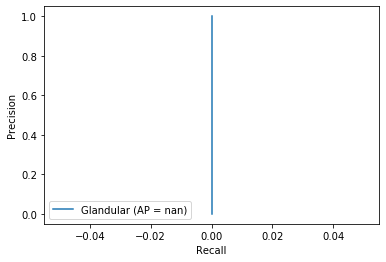

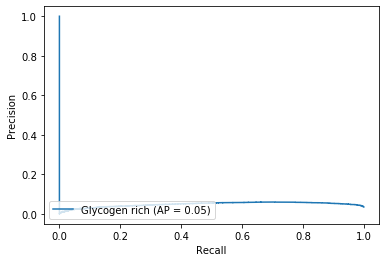

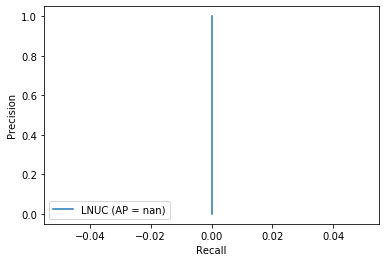

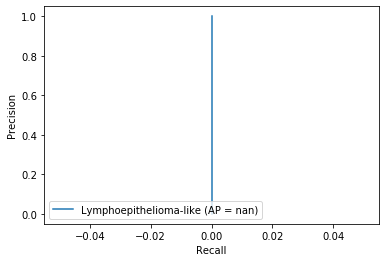

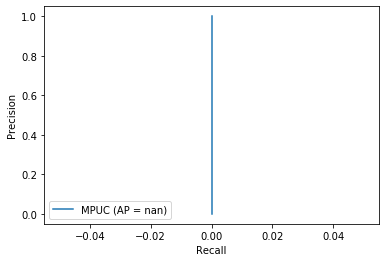

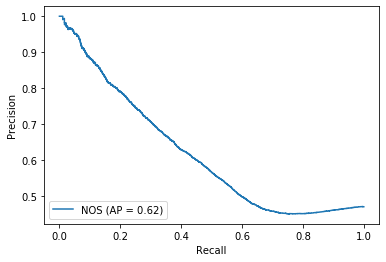

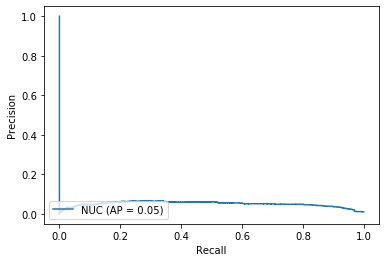

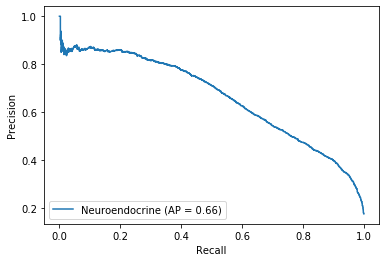

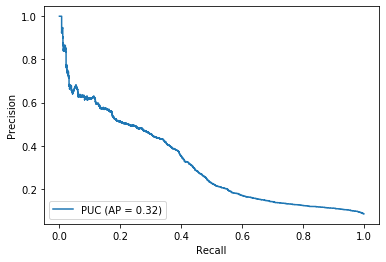

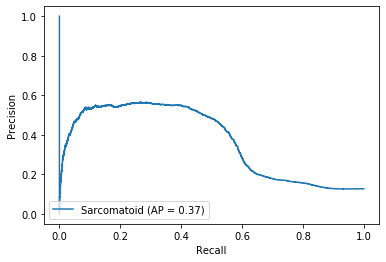

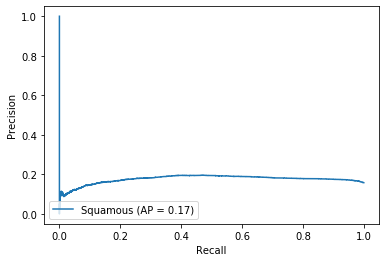

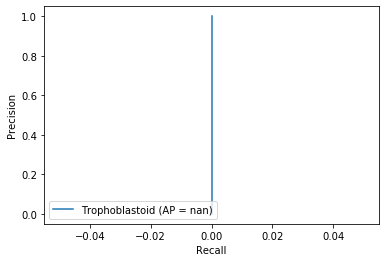

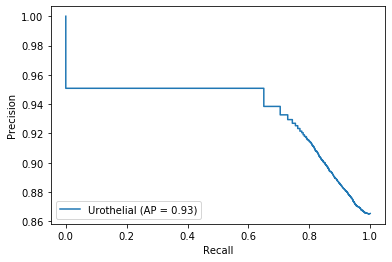

In [66]:
evaluator.plot_precision_recall_curves(level=shared.enums.EvaluationLevel.tile, 
                                       dataset_type=shared.enums.DatasetType.validation)

  0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/envs/DLM_Py3/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
 15%|█▌        | 2/13 [00:02<00:11,  1.04s/it]/opt/conda/envs/DLM_Py3/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
 23%|██▎       | 3/13 [00:03<00:10,  1.04s/it]/opt/conda/envs/DLM_Py3/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
 31%|███       | 4/13 [00:04<00:09,  1.04s/it]/opt/conda/envs/DLM_Py3/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricW

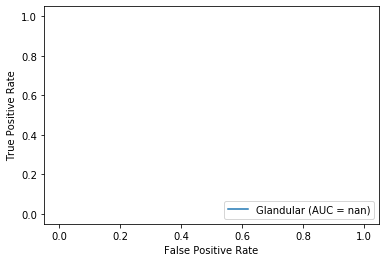

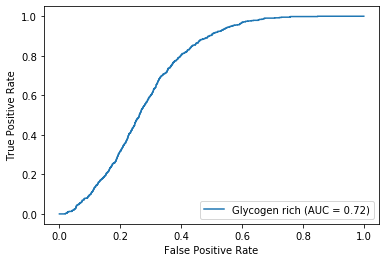

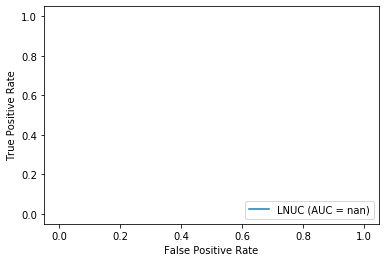

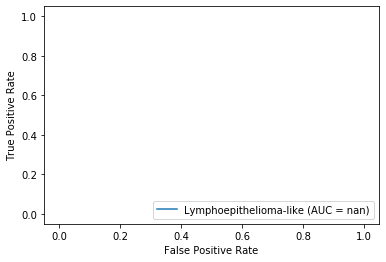

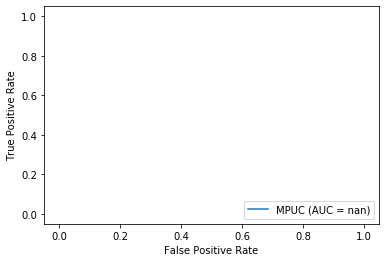

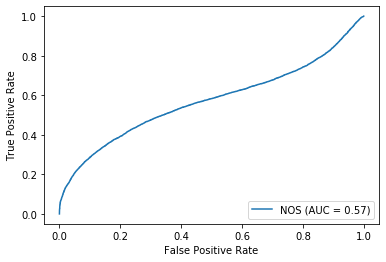

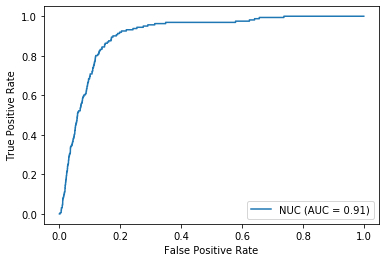

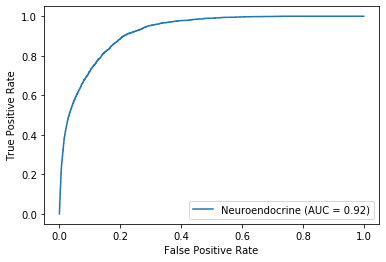

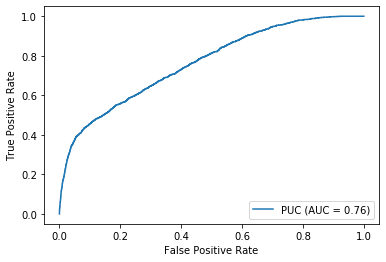

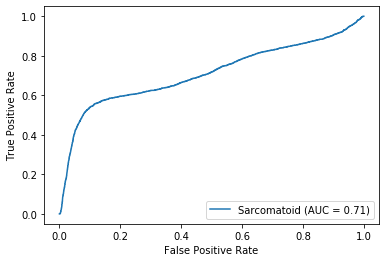

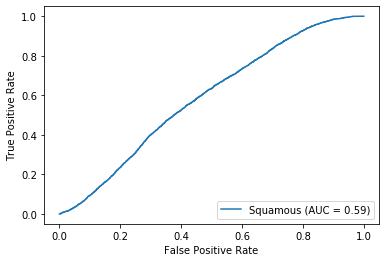

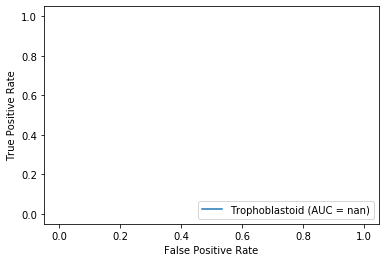

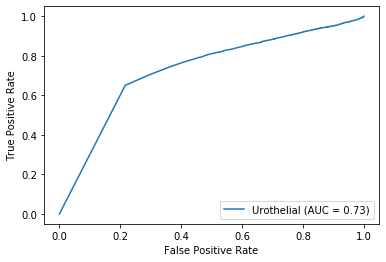

In [67]:
evaluator.plot_roc_curves(level=shared.enums.EvaluationLevel.tile, 
                                       dataset_type=shared.enums.DatasetType.validation)

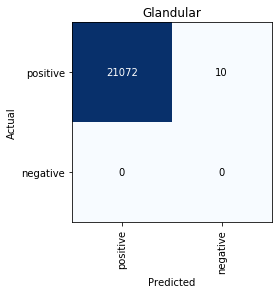

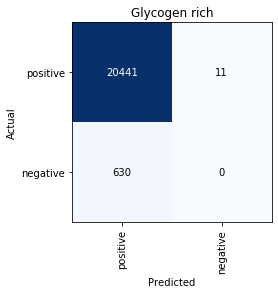

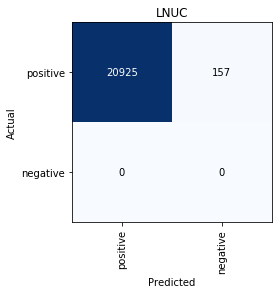

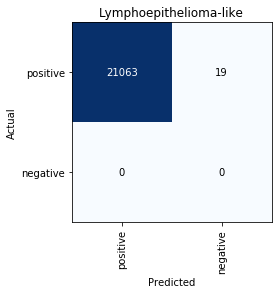

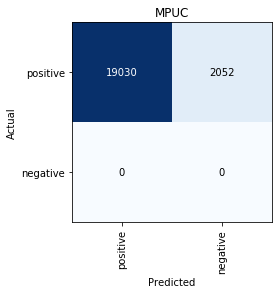

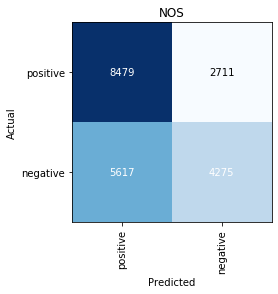

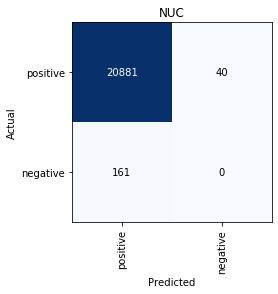

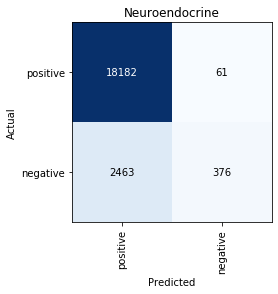

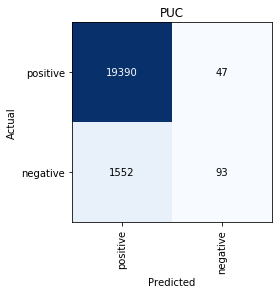

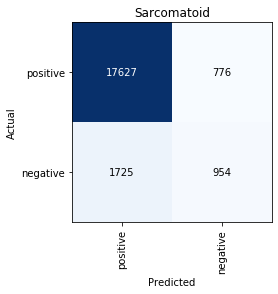

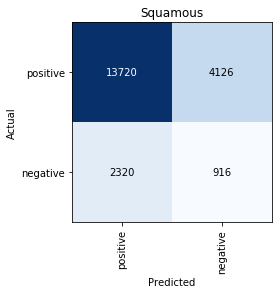

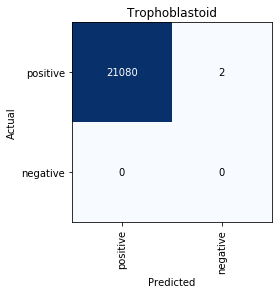

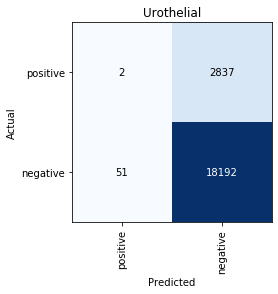

In [71]:
evaluator.plot_confusion_matrix(level=shared.enums.EvaluationLevel.tile, 
                                       dataset_type=shared.enums.DatasetType.validation)